In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 모든 경고 무시 (권장)
warnings.filterwarnings("ignore")

In [10]:
df4_backup = pd.read_csv('/content/drive/MyDrive/김경훈/recommendation/분석6/df4.csv')

In [99]:
df4 = df4_backup.sample(frac=0.1, random_state=42)
pd.set_option('display.max_columns', None)
df4

SEQ  BAS_YH      ATT_YM  AGE_encoded  SEX_CD_encoded  \
292546  MVEZ6J8TVJTASBNZ3SBS  2023q4  2004-08-01            5               1   
103296  82O2BXA8HBURWRISIFKR  2023q4  2015-06-01            1               0   
217     00NGV9TCCI8P665USSLO  2023q4  2017-02-01            2               1   
386985  U9NDYI1XBKELVOCFOILJ  2023q4  2012-12-01            2               1   
412474  WAQREQP7ZB75W9V7CDGK  2023q4  2019-12-01            4               0   
...                      ...     ...         ...          ...             ...   
455415  ZOA8565GCCEHIFWNSJQN  2023q4  2014-12-01            3               1   
306588  NZ8211IZMA2XYYROLKXB  2023q4  2000-08-01            3               1   
353641  RNPJ3MUWOXFCDABE85AS  2023q4  2015-07-01            4               1   
354263  RPFRAYQA6YMMWL1JGFVY  2023q4  2009-12-01            3               0   
183686  ED4DX33EXYQ6WEPUN29V  2023q4  2014-02-01            5               1   

        MBR_RK_encoded  HOUS_SIDO_NM_encoded  LIFE_STAGE_encoded  \
292546               3                     8                   7   
103296               0                    13                   1   
217                  2                     1                   1   
386985               4                    16                   1   
412474               2                     1                   2   
...                ...                   ...                 ...   
455415               4                     8                   2   
306588               2                     8                   3   
353641               3                     8                   7   
354263               1                     1                   2   
183686               4                     8                   7   

        DIGT_CHNL_REG_YN_encoded  DIGT_CHNL_USE_YN_encoded  TOT_USE_AM_mean  \
292546                         1                         1           388.75   
103296                         1                         1          2060.00   
217                            1                         1           722.50   
386985                         0                         0           251.25   
412474                         0                         0           336.25   
...                          ...                       ...              ...   
455415                         1                         0            88.75   
306588                         1                         1           807.50   
353641                         1                         1           451.25   
354263                         0                         0          1856.25   
183686                         0                         0            42.50   

        CRDSL_USE_AM_mean  CNF_USE_AM_mean  INTERIOR_AM_mean  INSUHOS_AM_mean  \
292546             388.75              0.0               0.0            28.75   
103296            1870.00              0.0               0.0           380.00   
217                722.50              0.0               0.0             2.50   
386985             251.25              0.0               0.0             0.00   
412474             336.25              0.0               0.0             1.25   
...                   ...              ...               ...              ...   
455415              88.75              0.0               0.0             0.00   
306588             787.50              2.5               0.0            28.75   
353641             451.25              0.0               0.0             5.00   
354263            1761.25              0.0               0.0             0.00   
183686               0.00             42.5               0.0             5.00   

        OFFEDU_AM_mean  TRVLEC_AM_mean  FSBZ_AM_mean  SVCARC_AM_mean  \
292546            0.00             0.0        101.25           13.75   
103296            0.00             2.5        326.25           53.75   
217              42.50             0.0         32.50           17.50   
386985            0.00   

## 0. 전처리

In [100]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

df4 = df4.set_index('SEQ')
features = df4.drop(columns=['BAS_YH','ATT_YM'])

# ✅ Hopkins 통계량 계산 함수
def hopkins(X, sample_size=0.1):
    if isinstance(X, pd.DataFrame):
        X = X.values

    n_samples = int(sample_size * X.shape[0])
    d = X.shape[1]

    np.random.seed(42)

    rand_indices = np.random.choice(range(X.shape[0]), n_samples, replace=False)
    X_sample = X[rand_indices]

    X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)
    X_uniform = np.random.uniform(X_min, X_max, (n_samples, d))

    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    u_distances, _ = nbrs.kneighbors(X_uniform)
    x_distances, _ = nbrs.kneighbors(X_sample)

    H = u_distances.sum() / (u_distances.sum() + x_distances.sum())
    return H

# ✅ 1. 전체 소비 변수 (신용/체크 포함)
columns = [
    #"DIGT_CHNL_REG_YN_encoded",	"DIGT_CHNL_USE_YN_encoded",
    "CRDSL_USE_AM_mean", "CNF_USE_AM_mean",  # 신용/체크
    "FUNITR_AM_mean", "APPLNC_AM_mean", "HLTHFS_AM_mean", "BLDMNG_AM_mean", "ARCHIT_AM_mean",
    "OPTIC_AM_mean", "AGRICTR_AM_mean", "LEISURE_S_AM_mean", "LEISURE_P_AM_mean", "CULTURE_AM_mean",
    "SANIT_AM_mean", "INSU_AM_mean", "OFFCOM_AM_mean", "BOOK_AM_mean", "RPR_AM_mean",
    "HOTEL_AM_mean", "GOODS_AM_mean", "TRVL_AM_mean", "FUEL_AM_mean", "SVC_AM_mean",
    "DISTBNP_AM_mean", "DISTBP_AM_mean", "GROCERY_AM_mean", "HOS_AM_mean", "CLOTH_AM_mean",
    "RESTRNT_AM_mean", "AUTOMNT_AM_mean", "AUTOSL_AM_mean", "KITWR_AM_mean", "FABRIC_AM_mean",
    "ACDM_AM_mean", "MBRSHOP_AM_mean"
]

# ✅ 2. 카테고리 소비 컬럼 (신용/체크 제외)
category_cols = [col for col in columns if col not in ["CRDSL_USE_AM_mean", "CNF_USE_AM_mean"]]

# ✅ 3. 총 소비 금액 → 카테고리별 비율(%) 파생
features["TOTAL_SPEND"] = features[category_cols].sum(axis=1)
for col in category_cols:
    features[f"{col}_RATIO"] = features[col] / features["TOTAL_SPEND"]

# ✅ 4. 신용/체크카드 비중 파생
features["CARD_TOTAL"] = features["CRDSL_USE_AM_mean"] + features["CNF_USE_AM_mean"]
features["CREDIT_RATIO"] = features["CRDSL_USE_AM_mean"] / features["CARD_TOTAL"]
features["CHECK_RATIO"] = features["CNF_USE_AM_mean"] / features["CARD_TOTAL"]

# ✅ 5. 비율 변수 목록
ratio_cols = [f"{col}_RATIO" for col in category_cols]

# ✅ 6. Top-10 카테고리 소비 비율 선택 (분산 기준)
variances = features[ratio_cols].var().sort_values(ascending=False)
top_10_cols = variances.head(8).index.tolist()

# ✅ 7. 최종 입력 변수 = Top-10 비율 + 신용/체크 비중
final_input_cols = top_10_cols + ["CREDIT_RATIO", "CHECK_RATIO"]
#+ [,"DIGT_CHNL_REG_YN_encoded",	"DIGT_CHNL_USE_YN_encoded"]
#final_input_cols = top_10_cols


# ✅ 9. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features[final_input_cols])

# ✅ 10. Hopkins 통계량 계산
hopkins_score = hopkins(X_scaled)
print(f"Hopkins 통계량: {hopkins_score:.4f}")

# ✅ 11. 해석 출력
if hopkins_score < 0.3:
    print("✔️ 클러스터링 구조가 뚜렷합니다. 군집화 적합한 데이터입니다.")
elif 0.3 <= hopkins_score <= 0.7:
    print("⚠️ 군집 구조가 약하거나 애매합니다. 클러스터 수(K)나 입력 변수 조정이 필요할 수 있습니다.")
else:
    print("❌ 무작위 구조로 보입니다. 클러스터링에 적합하지 않을 수 있습니다.")

Hopkins 통계량: 1.0000
❌ 무작위 구조로 보입니다. 클러스터링에 적합하지 않을 수 있습니다.


In [101]:
'''from scipy.stats import zscore

# ✅ 입력 데이터: 스케일링 전의 features[final_input_cols]
z_scores = np.abs(zscore(features[final_input_cols]))  # 절댓값 Z-Score 계산

# ✅ Z > 3인 값이 하나라도 있는 행 제거 (즉, 이상치 행 제거)
mask = (z_scores < 3).all(axis=1)
features = features[mask].copy()

print(f"✅ 이상치 제거 전: {features.shape[0]}개")
print(f"✅ 이상치 제거 후: {features_clean.shape[0]}개")
'''

'from scipy.stats import zscore\n\n# ✅ 입력 데이터: 스케일링 전의 features[final_input_cols]\nz_scores = np.abs(zscore(features[final_input_cols]))  # 절댓값 Z-Score 계산\n\n# ✅ Z > 3인 값이 하나라도 있는 행 제거 (즉, 이상치 행 제거)\nmask = (z_scores < 3).all(axis=1)\nfeatures = features[mask].copy()\n\nprint(f"✅ 이상치 제거 전: {features.shape[0]}개")\nprint(f"✅ 이상치 제거 후: {features_clean.shape[0]}개")\n'

## 클러스터링

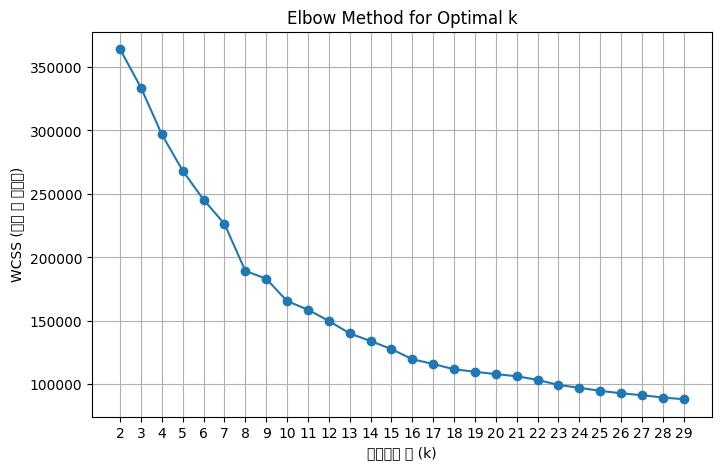

In [102]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# ✅ 2. 클러스터 수 범위 설정
k_range = range(2, 30)
wcss = []  # 군집 내 제곱합

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS

# ✅ 3. 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.xticks(k_range)
plt.xlabel("클러스터 수 (k)")
plt.ylabel("WCSS (군집 내 제곱합)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


In [146]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(8, 12)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=7)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k = {k} → 실루엣 점수 = {score:.4f}")


k = 8 → 실루엣 점수 = 0.2739
k = 9 → 실루엣 점수 = 0.2678
k = 10 → 실루엣 점수 = 0.2332
k = 11 → 실루엣 점수 = 0.2359


In [141]:
kmeans = KMeans(n_clusters=10, random_state=7)
features["CLUSTER"] = kmeans.fit_predict(X_scaled)

features.head()

AGE_encoded  SEX_CD_encoded  MBR_RK_encoded  \
SEQ                                                                 
MVEZ6J8TVJTASBNZ3SBS            5               1               3   
82O2BXA8HBURWRISIFKR            1               0               0   
00NGV9TCCI8P665USSLO            2               1               2   
U9NDYI1XBKELVOCFOILJ            2               1               4   
WAQREQP7ZB75W9V7CDGK            4               0               2   

                      HOUS_SIDO_NM_encoded  LIFE_STAGE_encoded  \
SEQ                                                              
MVEZ6J8TVJTASBNZ3SBS                     8                   7   
82O2BXA8HBURWRISIFKR                    13                   1   
00NGV9TCCI8P665USSLO                     1                   1   
U9NDYI1XBKELVOCFOILJ                    16                   1   
WAQREQP7ZB75W9V7CDGK                     1                   2   

                      DIGT_CHNL_REG_YN_encoded  DIGT_CHNL_USE_YN_encoded  \
SEQ                                                                        
MVEZ6J8TVJTASBNZ3SBS                         1                         1   
82O2BXA8HBURWRISIFKR                         1                         1   
00NGV9TCCI8P665USSLO                         1                         1   
U9NDYI1XBKELVOCFOILJ                         0                         0   
WAQREQP7ZB75W9V7CDGK                         0                         0   

                      TOT_USE_AM_mean  CRDSL_USE_AM_mean  CNF_USE_AM_mean  \
SEQ                                                                         
MVEZ6J8TVJTASBNZ3SBS           388.75             388.75              0.0   
82O2BXA8HBURWRISIFKR          2060.00            1870.00              0.0   
00NGV9TCCI8P665USSLO           722.50             722.50              0.0   
U9NDYI1XBKELVOCFOILJ           251.25             251.25              0.0   
WAQREQP7ZB75W9V7CDGK           336.25             336.25              0.0   

                      INTERIOR_AM_mean  INSUHOS_AM_mean  OFFEDU_AM_mean  \
SEQ                                                                       
MVEZ6J8TVJTASBNZ3SBS               0.0            28.75             0.0   
82O2BXA8HBURWRISIFKR               0.0           380.00             0.0   
00NGV9TCCI8P665USSLO               0.0             2.50            42.5   
U9NDYI1XBKELVOCFOILJ               0.0             0.00             0.0   
WAQREQP7ZB75W9V7CDGK               0.0             1.25             0.0   

                      TRVLEC_AM_mean  FSBZ_AM_mean  SVCARC_AM_mean  \
SEQ                                                                  
MVEZ6J8TVJTASBNZ3SBS             0.0        101.25           13.75   
82O2BXA8HBURWRISIFKR             2.5        326.25           53.75   
00NGV9TCCI8P665USSLO             0.0         32.50           17.50   
U9NDYI1XBKELVOCFOILJ             0.0          0.00           48.75   
WAQREQP7ZB75W9V7CDGK             5.0         48.75           32.50   

                      DIST_AM_mean  PLSANIT_AM_mean  CLOTHGDS_AM_mean  \
SEQ                                                                     
MVEZ6J8TVJTASBNZ3SBS        136.25              0.0             41.25   
82O2BXA8HBURWRISIFKR        910.00             70.0              0.00   
00NGV9TCCI8P665USSLO         96.25              0.0              0.00   
U9NDYI1XBKELVOCFOILJ        195.00              0.0              0.00   
WAQREQP7ZB75W9V7CDGK        205.00              0.0              0.00   

                      AUTO_AM_mean  FUNITR_AM_mean  APPLNC_AM_mean  \
SEQ                                                                  
MVEZ6J8TVJTASBNZ3SBS           0.0             0.0             0.0   
82O2BXA8HBURWRISIFKR          47.5             0.0             0.0   
00NGV9TCCI8P665USSLO           0.0             0.0             0.0   
U9NDYI1XBKELVOCFOILJ           0.0             0.0             0.0   
WAQREQP7ZB75W9V7CDGK          20.0             0.0   

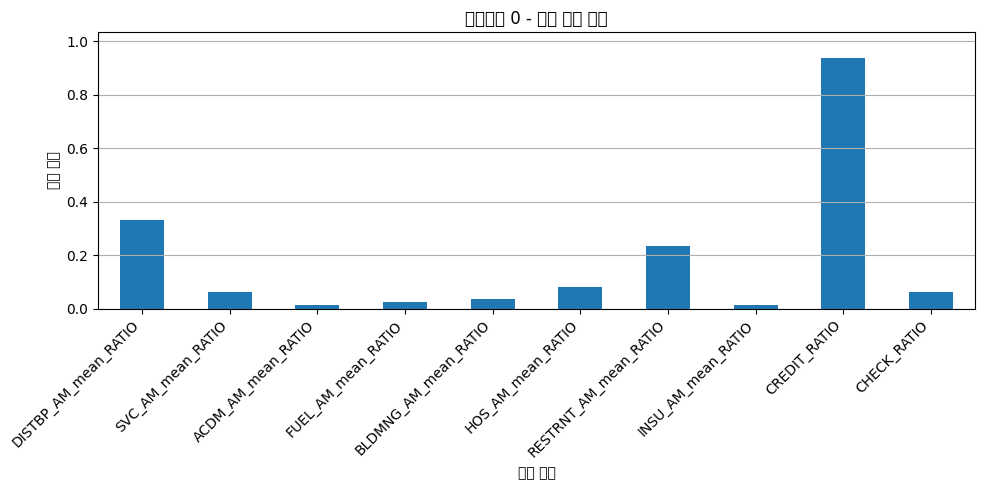

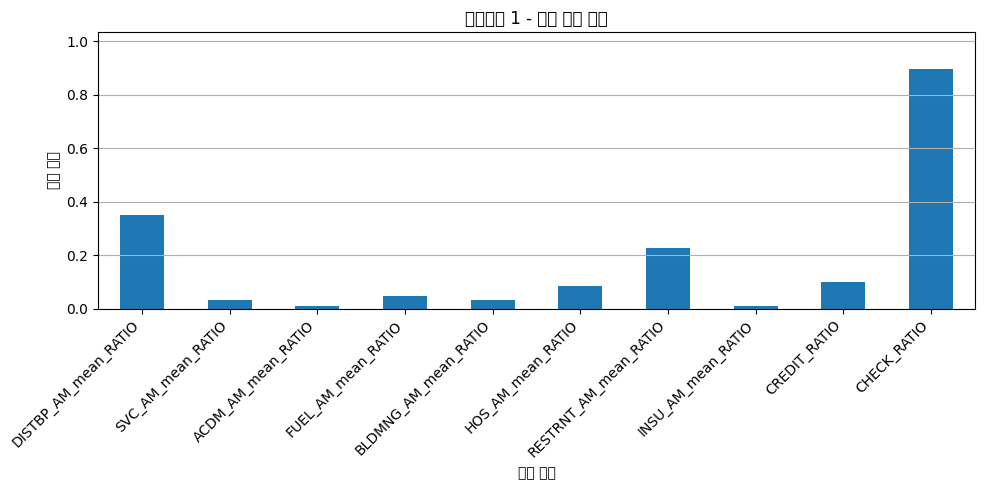

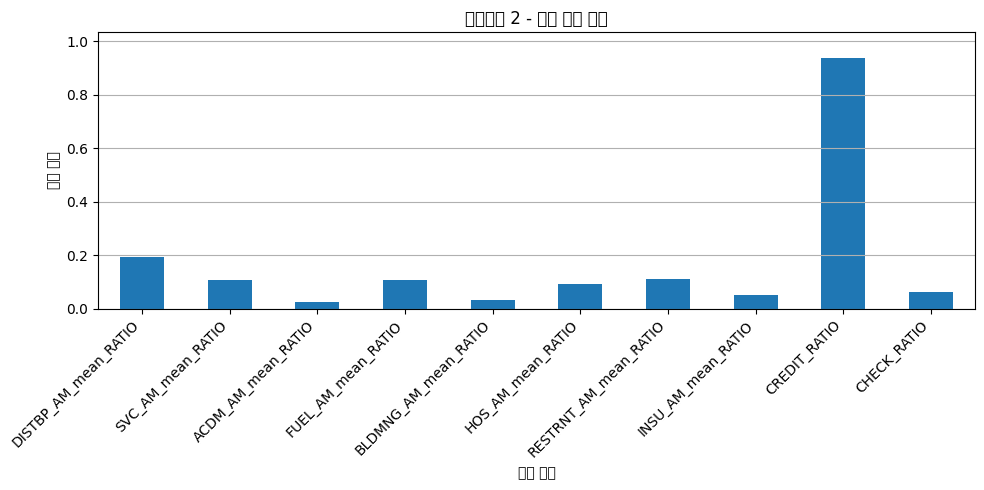

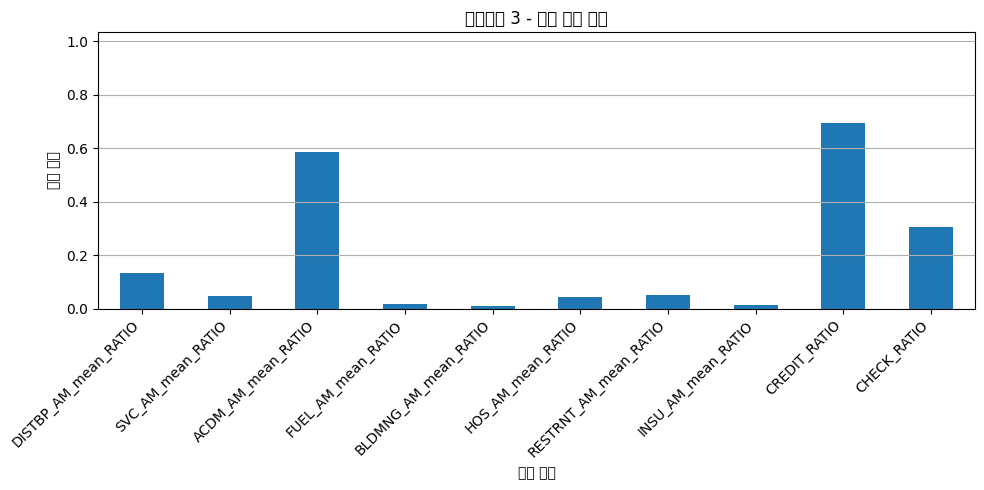

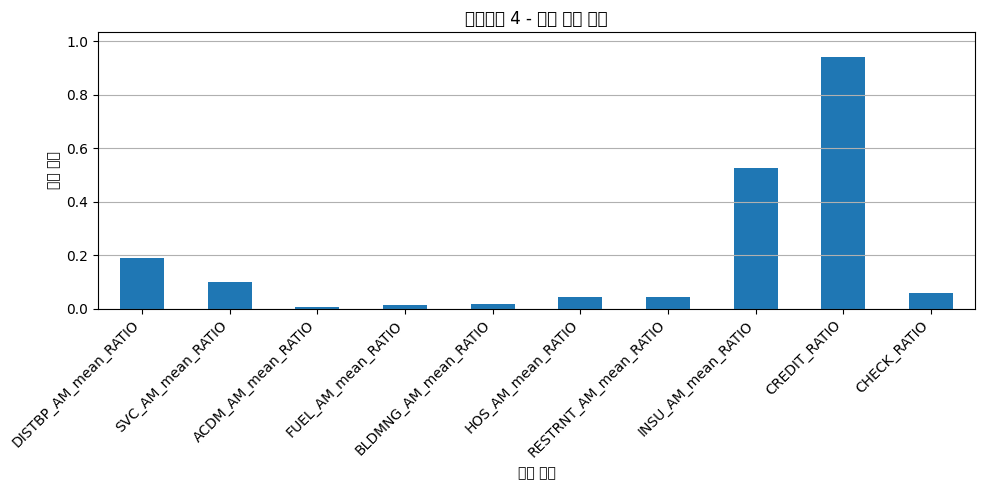

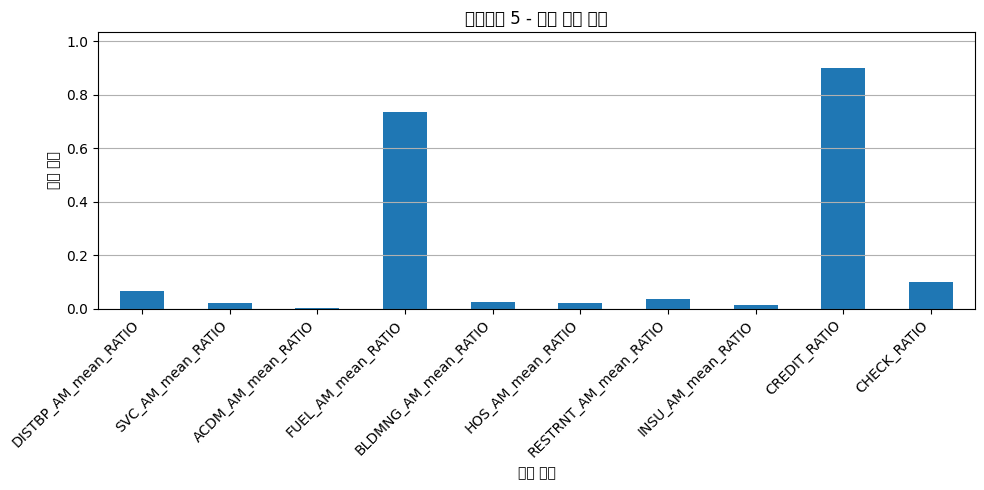

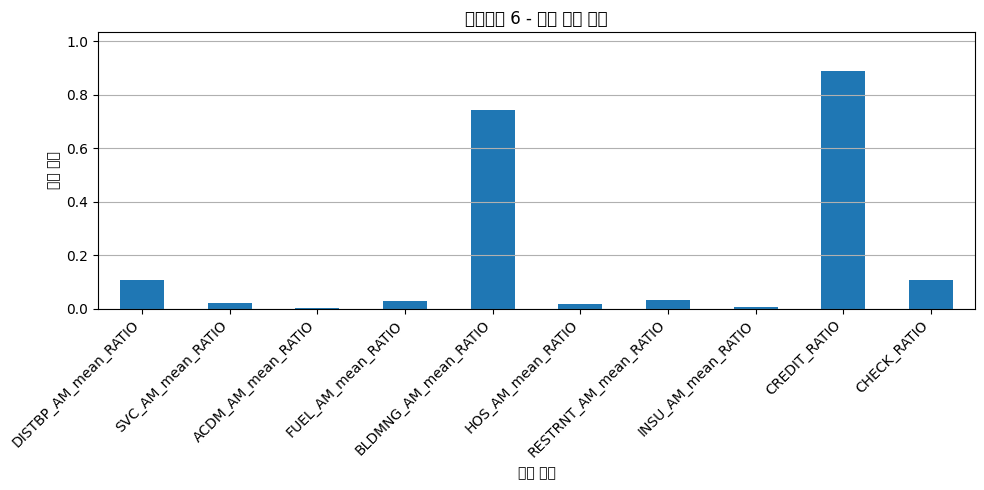

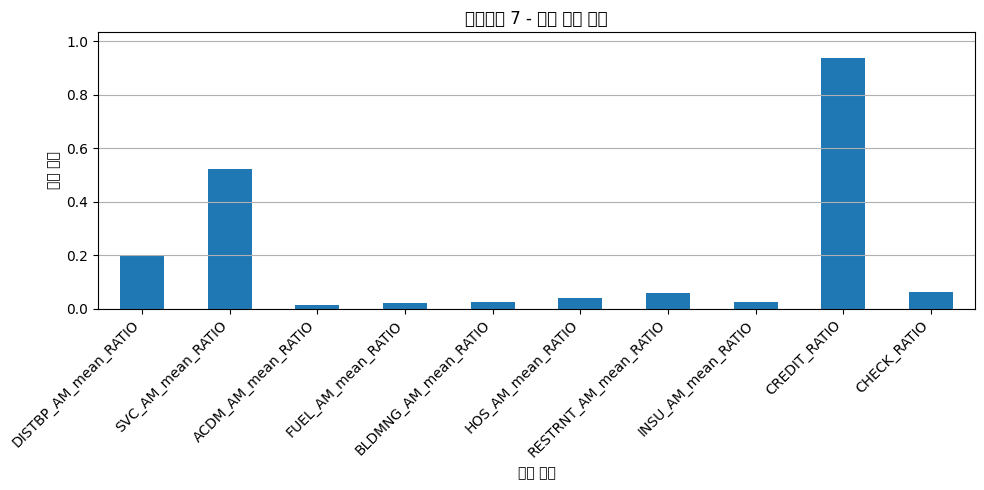

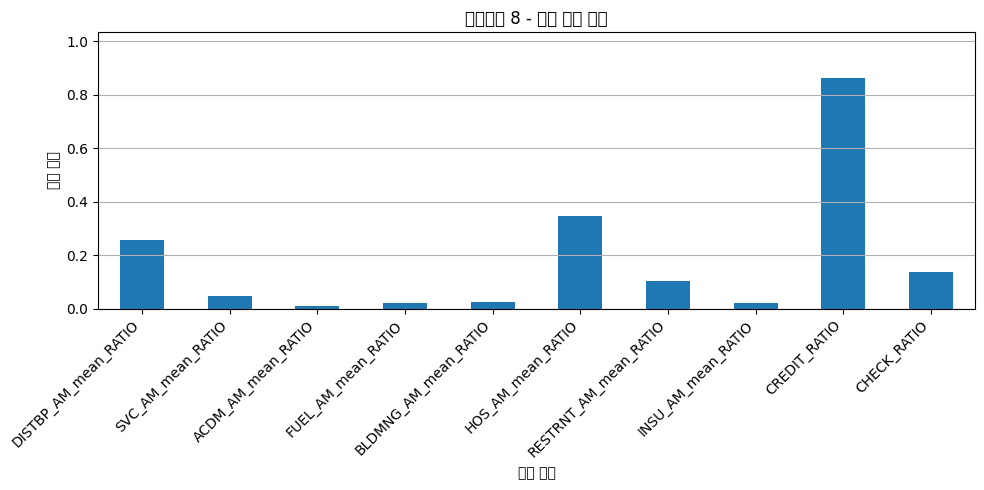

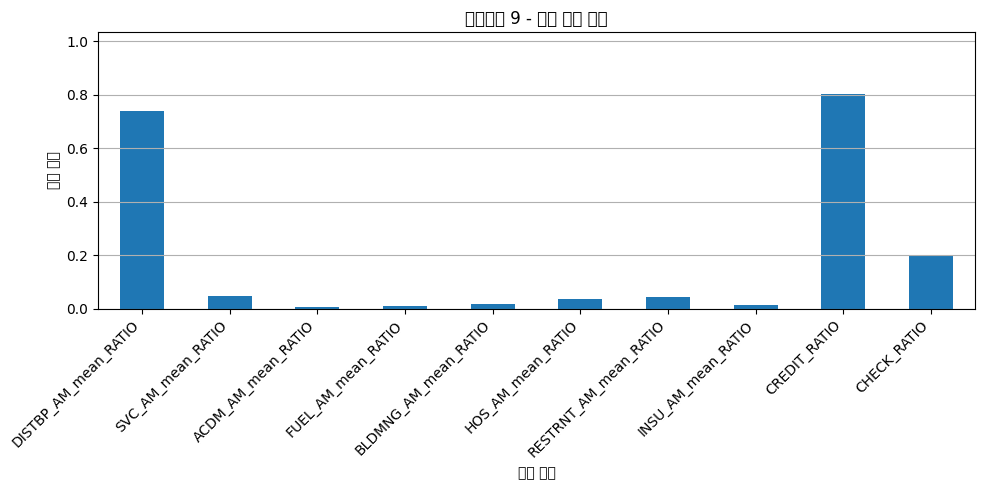

In [142]:
import matplotlib.pyplot as plt

# ✅ 12. 클러스터별 소비 특성 평균
cluster_profile = features.groupby("CLUSTER")[final_input_cols].mean()

# 클러스터 개수 추출
n_clusters = cluster_profile.shape[0]

# 클러스터별 개별 시각화
for cluster_id in range(n_clusters):
    plt.figure(figsize=(10, 5))
    cluster_profile.loc[cluster_id].plot(kind='bar')
    plt.title(f"클러스터 {cluster_id} - 평균 소비 성향")
    plt.xlabel("소비 항목")
    plt.ylabel("평균 비율")
    plt.ylim(0, cluster_profile.max().max() * 1.1)  # y축 스케일 통일
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [143]:
df4['cluster'] = features["CLUSTER"]
df4.head()

BAS_YH      ATT_YM  AGE_encoded  SEX_CD_encoded  \
SEQ                                                                     
MVEZ6J8TVJTASBNZ3SBS  2023q4  2004-08-01            5               1   
82O2BXA8HBURWRISIFKR  2023q4  2015-06-01            1               0   
00NGV9TCCI8P665USSLO  2023q4  2017-02-01            2               1   
U9NDYI1XBKELVOCFOILJ  2023q4  2012-12-01            2               1   
WAQREQP7ZB75W9V7CDGK  2023q4  2019-12-01            4               0   

                      MBR_RK_encoded  HOUS_SIDO_NM_encoded  \
SEQ                                                          
MVEZ6J8TVJTASBNZ3SBS               3                     8   
82O2BXA8HBURWRISIFKR               0                    13   
00NGV9TCCI8P665USSLO               2                     1   
U9NDYI1XBKELVOCFOILJ               4                    16   
WAQREQP7ZB75W9V7CDGK               2                     1   

                      LIFE_STAGE_encoded  DIGT_CHNL_REG_YN_encoded  \
SEQ                                                                  
MVEZ6J8TVJTASBNZ3SBS                   7                         1   
82O2BXA8HBURWRISIFKR                   1                         1   
00NGV9TCCI8P665USSLO                   1                         1   
U9NDYI1XBKELVOCFOILJ                   1                         0   
WAQREQP7ZB75W9V7CDGK                   2                         0   

                      DIGT_CHNL_USE_YN_encoded  TOT_USE_AM_mean  \
SEQ                                                               
MVEZ6J8TVJTASBNZ3SBS                         1           388.75   
82O2BXA8HBURWRISIFKR                         1          2060.00   
00NGV9TCCI8P665USSLO                         1           722.50   
U9NDYI1XBKELVOCFOILJ                         0           251.25   
WAQREQP7ZB75W9V7CDGK                         0           336.25   

                      CRDSL_USE_AM_mean  CNF_USE_AM_mean  INTERIOR_AM_mean  \
SEQ                                                                          
MVEZ6J8TVJTASBNZ3SBS             388.75              0.0               0.0   
82O2BXA8HBURWRISIFKR            1870.00              0.0               0.0   
00NGV9TCCI8P665USSLO             722.50              0.0               0.0   
U9NDYI1XBKELVOCFOILJ             251.25              0.0               0.0   
WAQREQP7ZB75W9V7CDGK             336.25              0.0               0.0   

                      INSUHOS_AM_mean  OFFEDU_AM_mean  TRVLEC_AM_mean  \
SEQ                                                                     
MVEZ6J8TVJTASBNZ3SBS            28.75             0.0             0.0   
82O2BXA8HBURWRISIFKR           380.00             0.0             2.5   
00NGV9TCCI8P665USSLO             2.50            42.5             0.0   
U9NDYI1XBKELVOCFOILJ             0.00             0.0             0.0   
WAQREQP7ZB75W9V7CDGK             1.25             0.0             5.0   

                      FSBZ_AM_mean  SVCARC_AM_mean  DIST_AM_mean  \
SEQ                                                                
MVEZ6J8TVJTASBNZ3SBS        101.25           13.75        136.25   
82O2BXA8HBURWRISIFKR        326.25           53.75        910.00   
00NGV9TCCI8P665USSLO         32.50           17.50         96.25   
U9NDYI1XBKELVOCFOILJ          0.00           48.75        195.00   
WAQREQP7ZB75W9V7CDGK         48.75           32.50        205.00   

                      PLSANIT_AM_mean  CLOTHGDS_AM_mean  AUTO_AM_mean  \
SEQ                                                                     
MVEZ6J8TVJTASBNZ3SBS              0.0             41.25           0.0   
82O2BXA8HBURWRISIFKR             70.0              0.00          47.5   
00NGV9TCCI8P665USSLO              0.0              0.00           0.0   
U9NDYI1XBKELVOCFOILJ              0.0              0.00           0.0   
WAQREQP7ZB75W9V7CDGK              0.0              0.00          20.0   

                      FUNITR_AM_mean  APPLNC_AM_mean  HLTHFS_AM_me

In [144]:
df_copy = df4.copy()

In [145]:
(df_copy['cluster'].value_counts()/len(df_copy)*100).sort_index()

cluster
0    15.152109
1    25.362319
2    23.214519
3     4.587196
4     3.281542
5     1.586369
6     1.682117
7     8.312660
8     8.871915
9     7.949254
Name: count, dtype: float64

### DBSCAN

In [62]:
!pip install -q hdbscan


In [64]:
import hdbscan
import matplotlib.pyplot as plt

# ✅ HDBSCAN 클러스터링
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)  # 필요 시 min_cluster_size 조정
features["CLUSTER"] = clusterer.fit_predict(X_scaled)

# ✅ 클러스터 라벨 확인
print(features["CLUSTER"].value_counts().sort_index())


CLUSTER
-1      39287
 0         13
 1          8
 2          7
 3          5
        ...  
 502       20
 503       19
 504        6
 505       19
 506        7
Name: count, Length: 508, dtype: int64


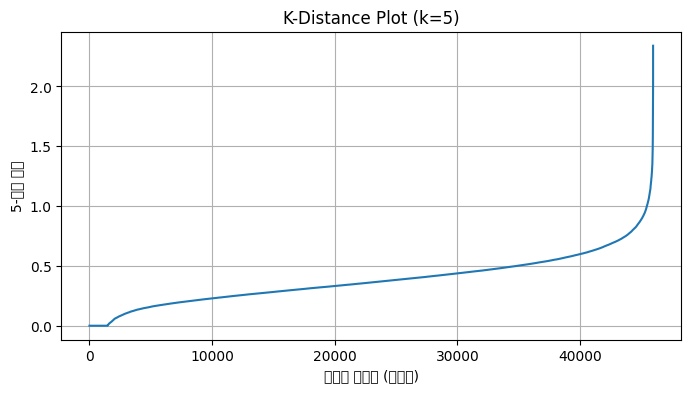

In [65]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# k = min_samples - 1 사용 권장 (기본은 4~5)
k = 5
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled)
distances, indices = neigh.kneighbors(X_scaled)

# k번째 이웃 거리만 추출 → 정렬
k_distances = np.sort(distances[:, k-1])

# 시각화
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title(f"K-Distance Plot (k={k})")
plt.xlabel("데이터 포인트 (정렬됨)")
plt.ylabel(f"{k}-최소 거리")
plt.grid(True)
plt.show()


In [67]:
from sklearn.cluster import DBSCAN

# 위에서 정한 eps 값 사용 (예: 0.25), min_samples는 5 정도부터 시도
dbscan = DBSCAN(eps=0.6, min_samples=10)
features["CLUSTER"] = dbscan.fit_predict(X_scaled)

print(features["CLUSTER"].value_counts().sort_index())


CLUSTER
-1      5356
 0     40039
 1       405
 2        16
 3        25
 4        38
 5        19
 6        11
 7        12
 8        10
 9         9
 10        5
 11        9
Name: count, dtype: int64


### 범주형 변수

In [ ]:
categorical_vars = ['AGE', 'SEX_CD', 'MBR_RK', 'LIFE_STAGE', 'DIGT_CHNL_REG_YN', 'DIGT_CHNL_USE_YN',  'TOP_SPENDING_CATEGORY', 'HOUS_SIDO_NM_GROUPED']

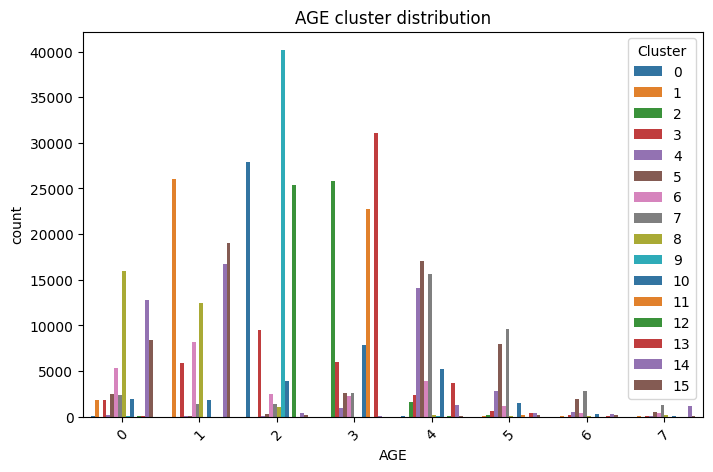

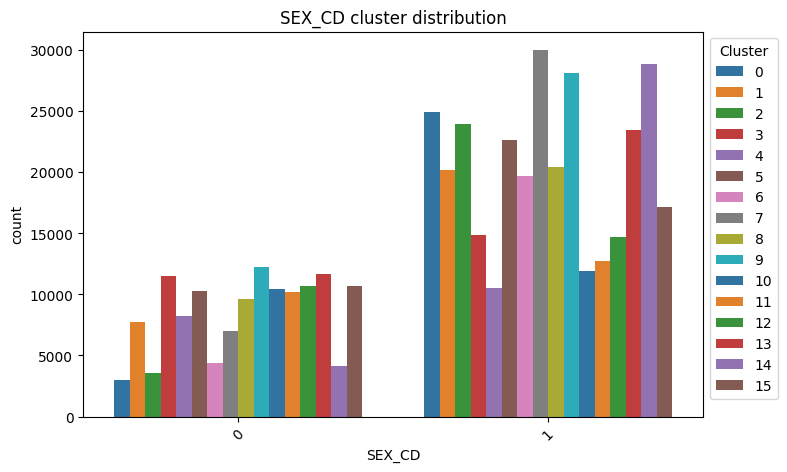

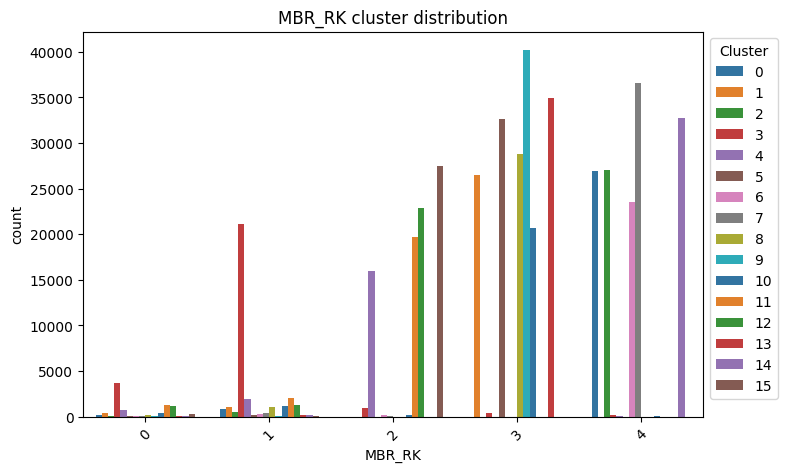

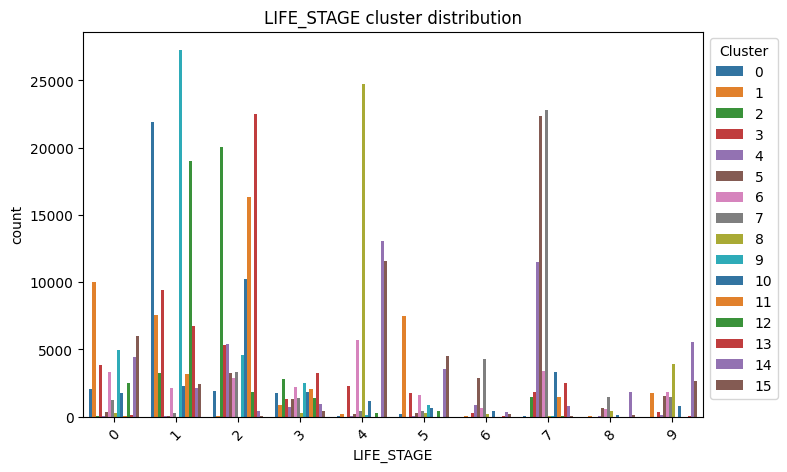

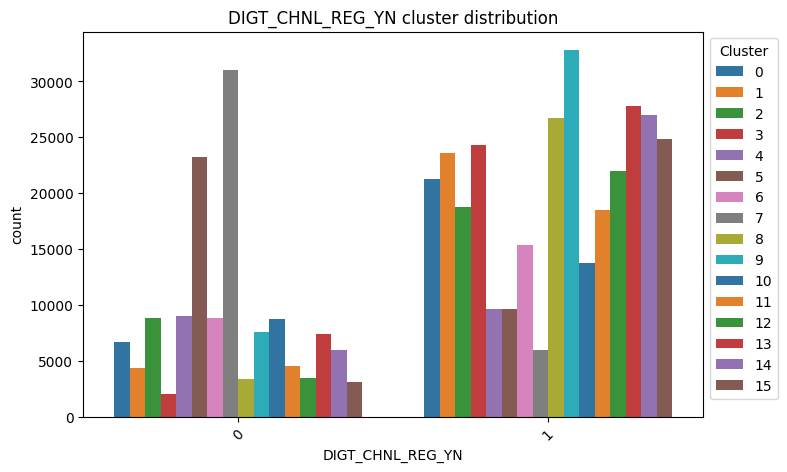

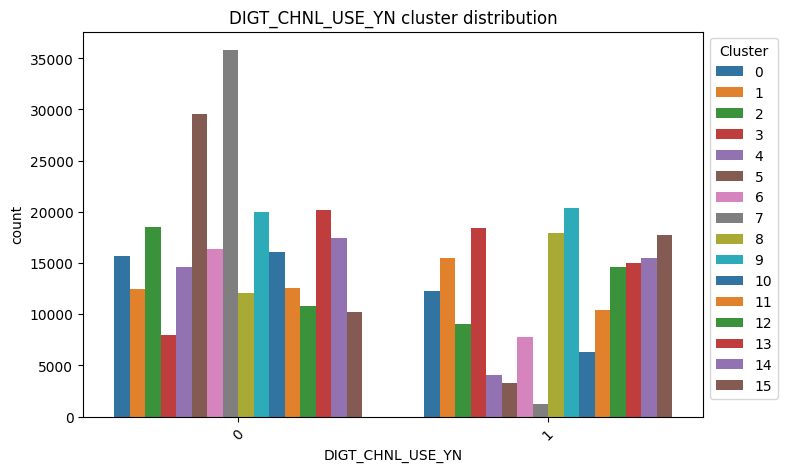

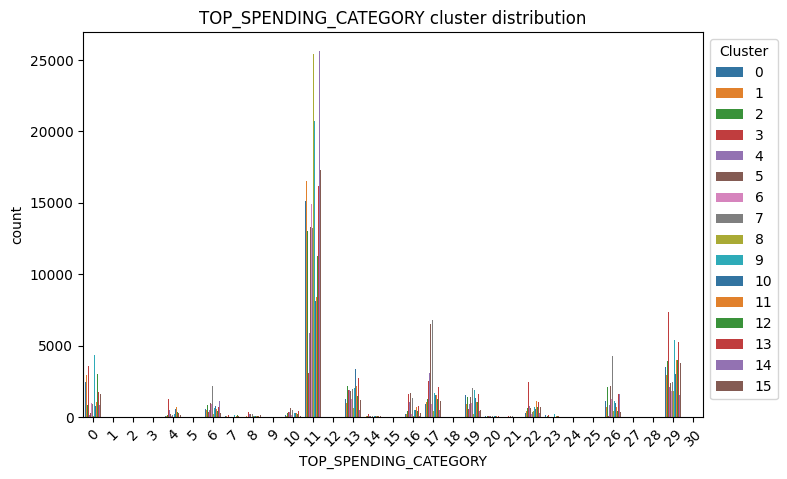

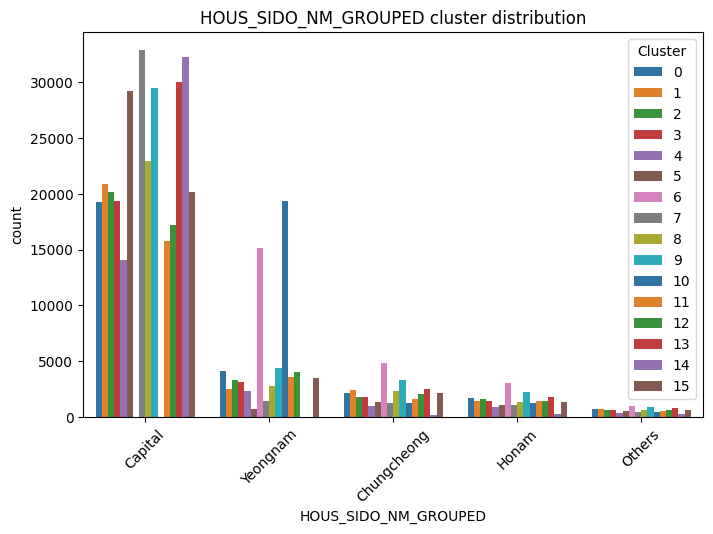

In [ ]:
for cat in categorical_vars:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=cat, hue="cluster", data=features_copy, palette="tab10")
    plt.title(f"{cat} cluster distribution")
    plt.xticks(rotation=45)
    plt.legend(title="Cluster", bbox_to_anchor=(1, 1))
    plt.show()

▶Cluster 0


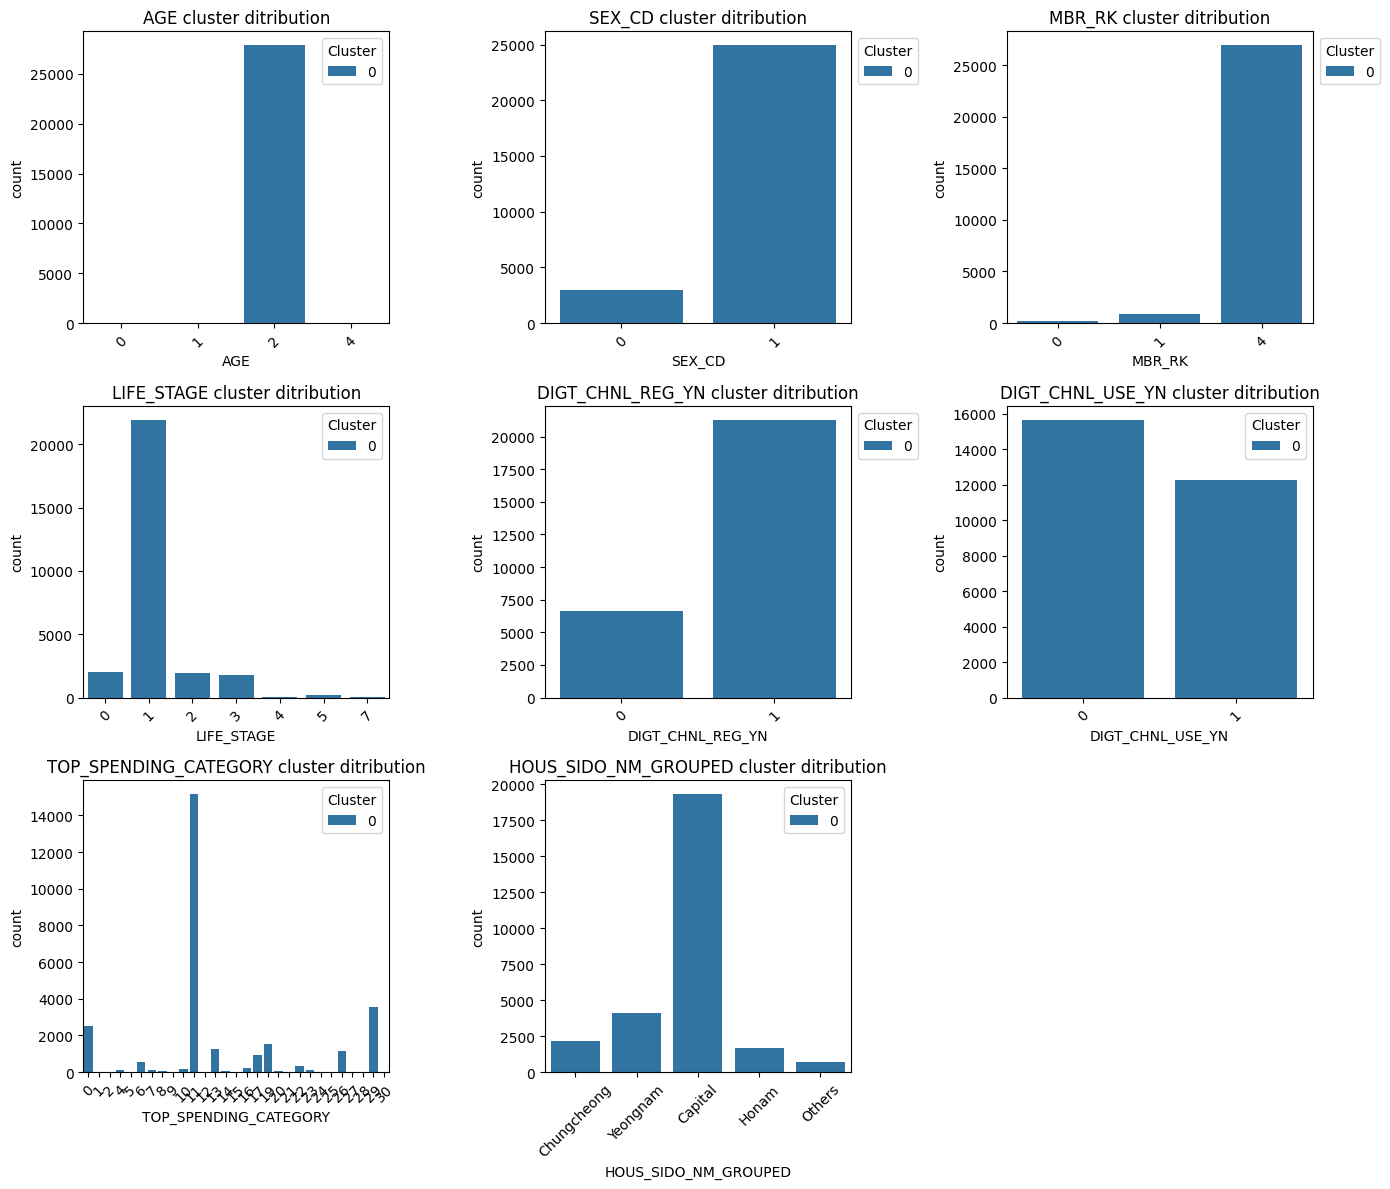


▶Cluster 1


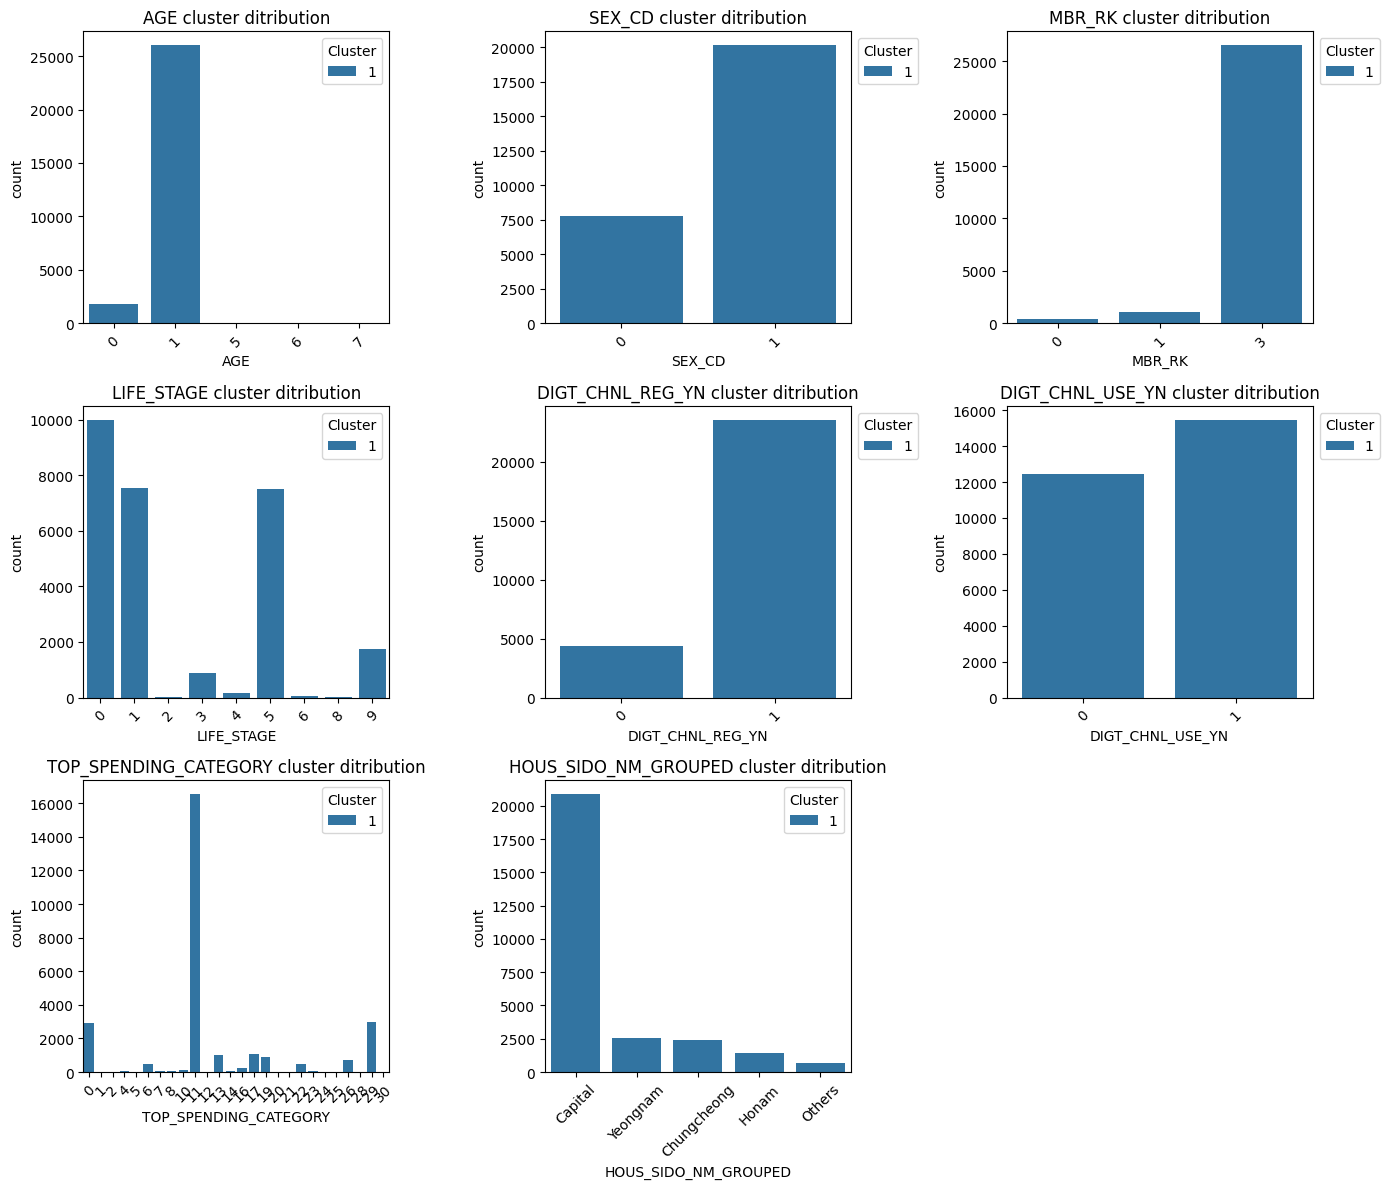


▶Cluster 2


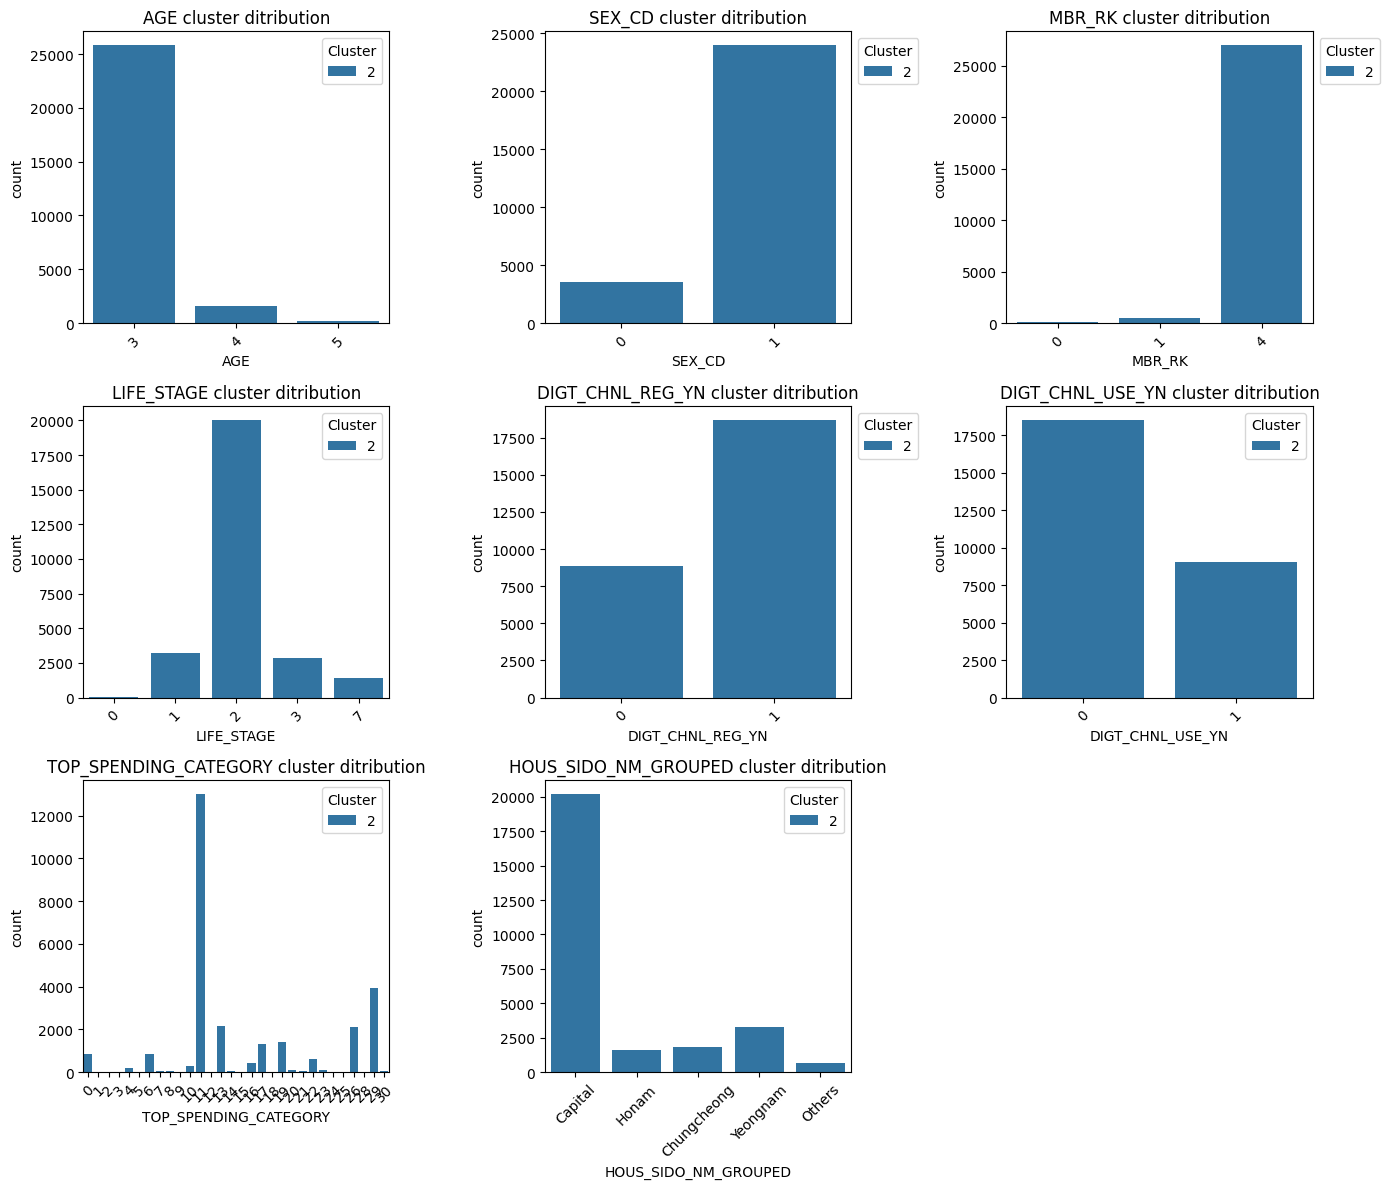


▶Cluster 3


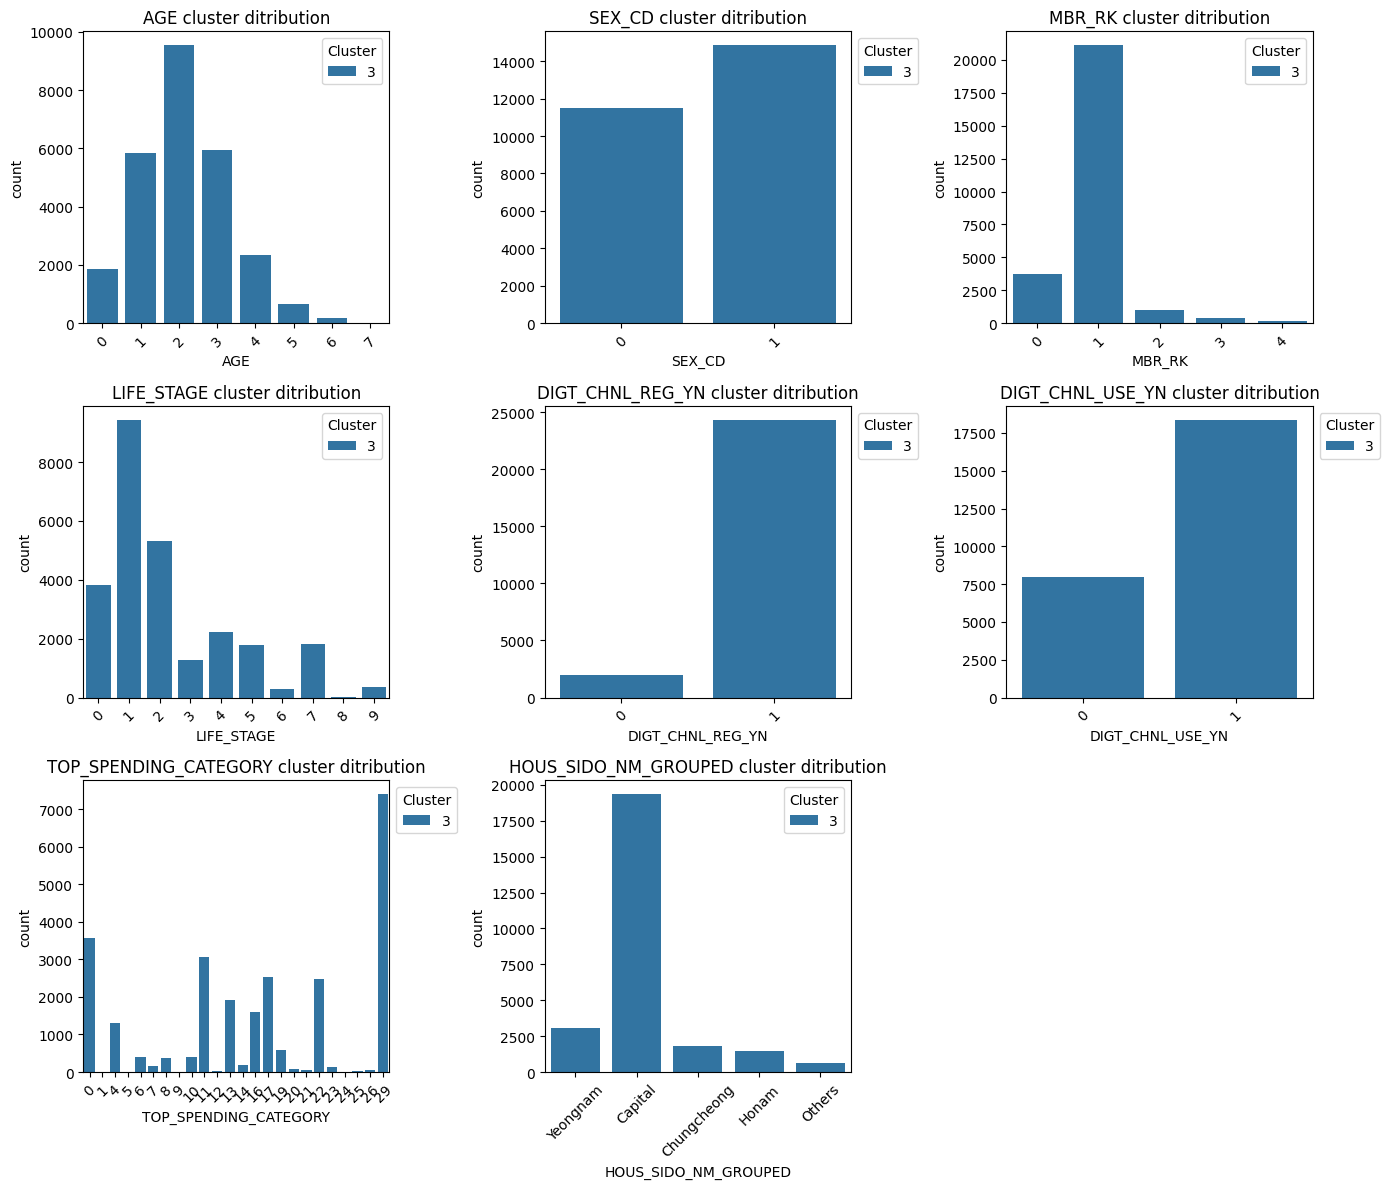


▶Cluster 4


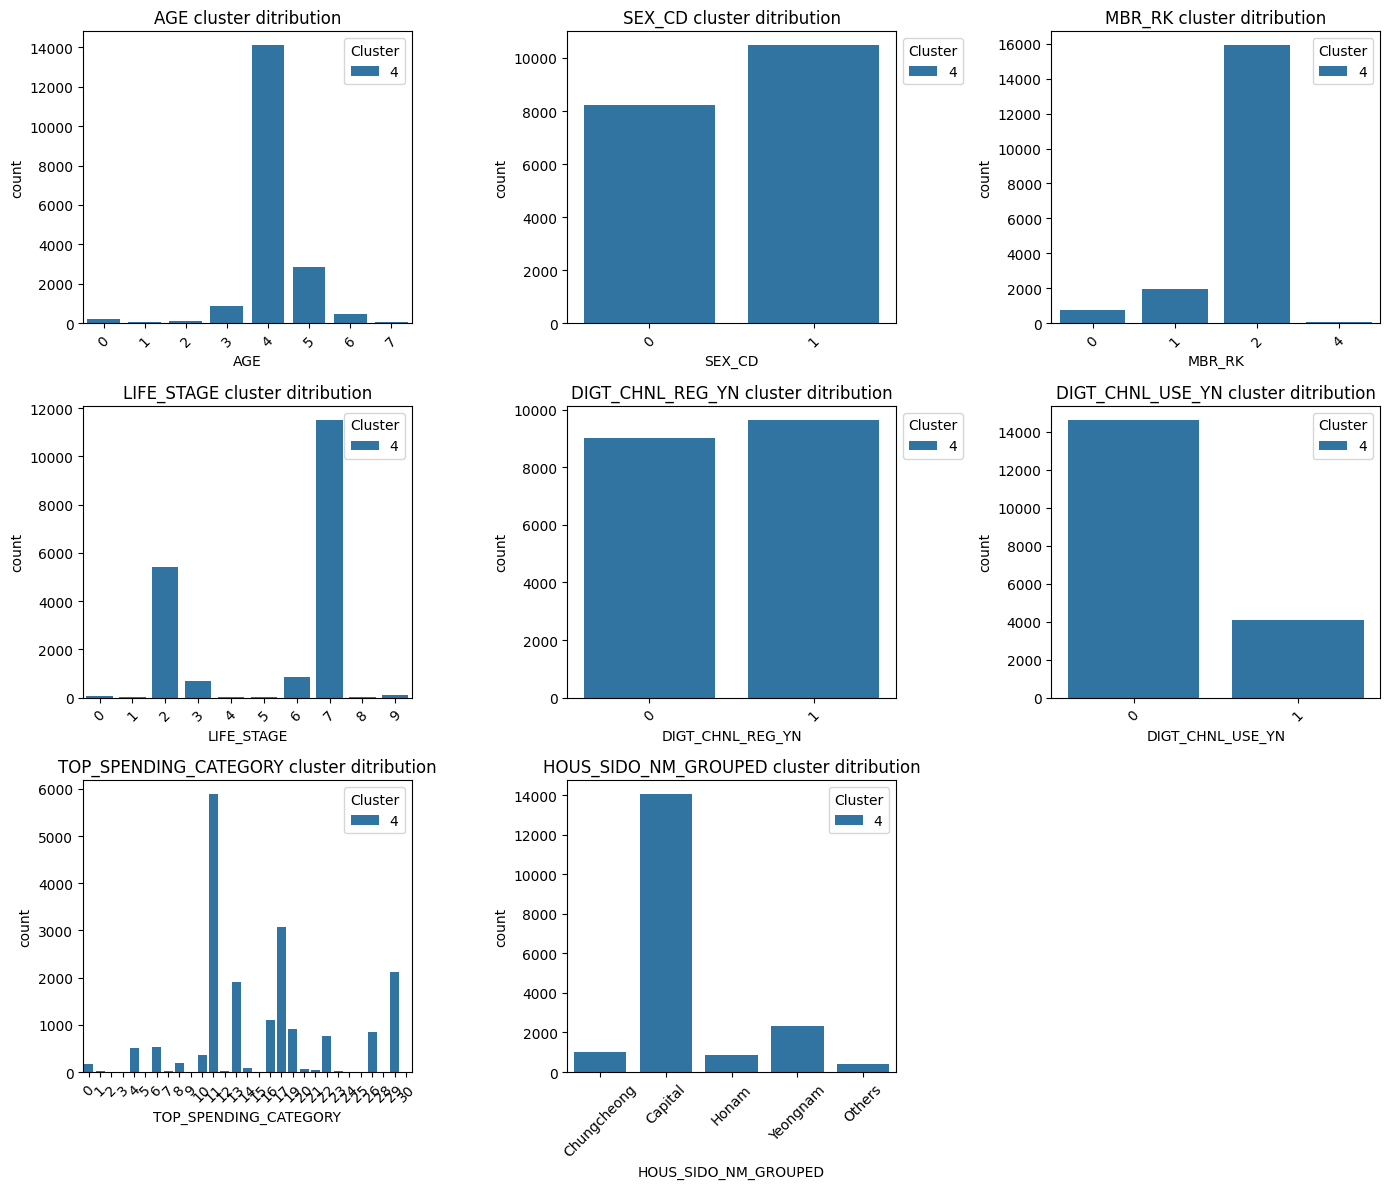


▶Cluster 5


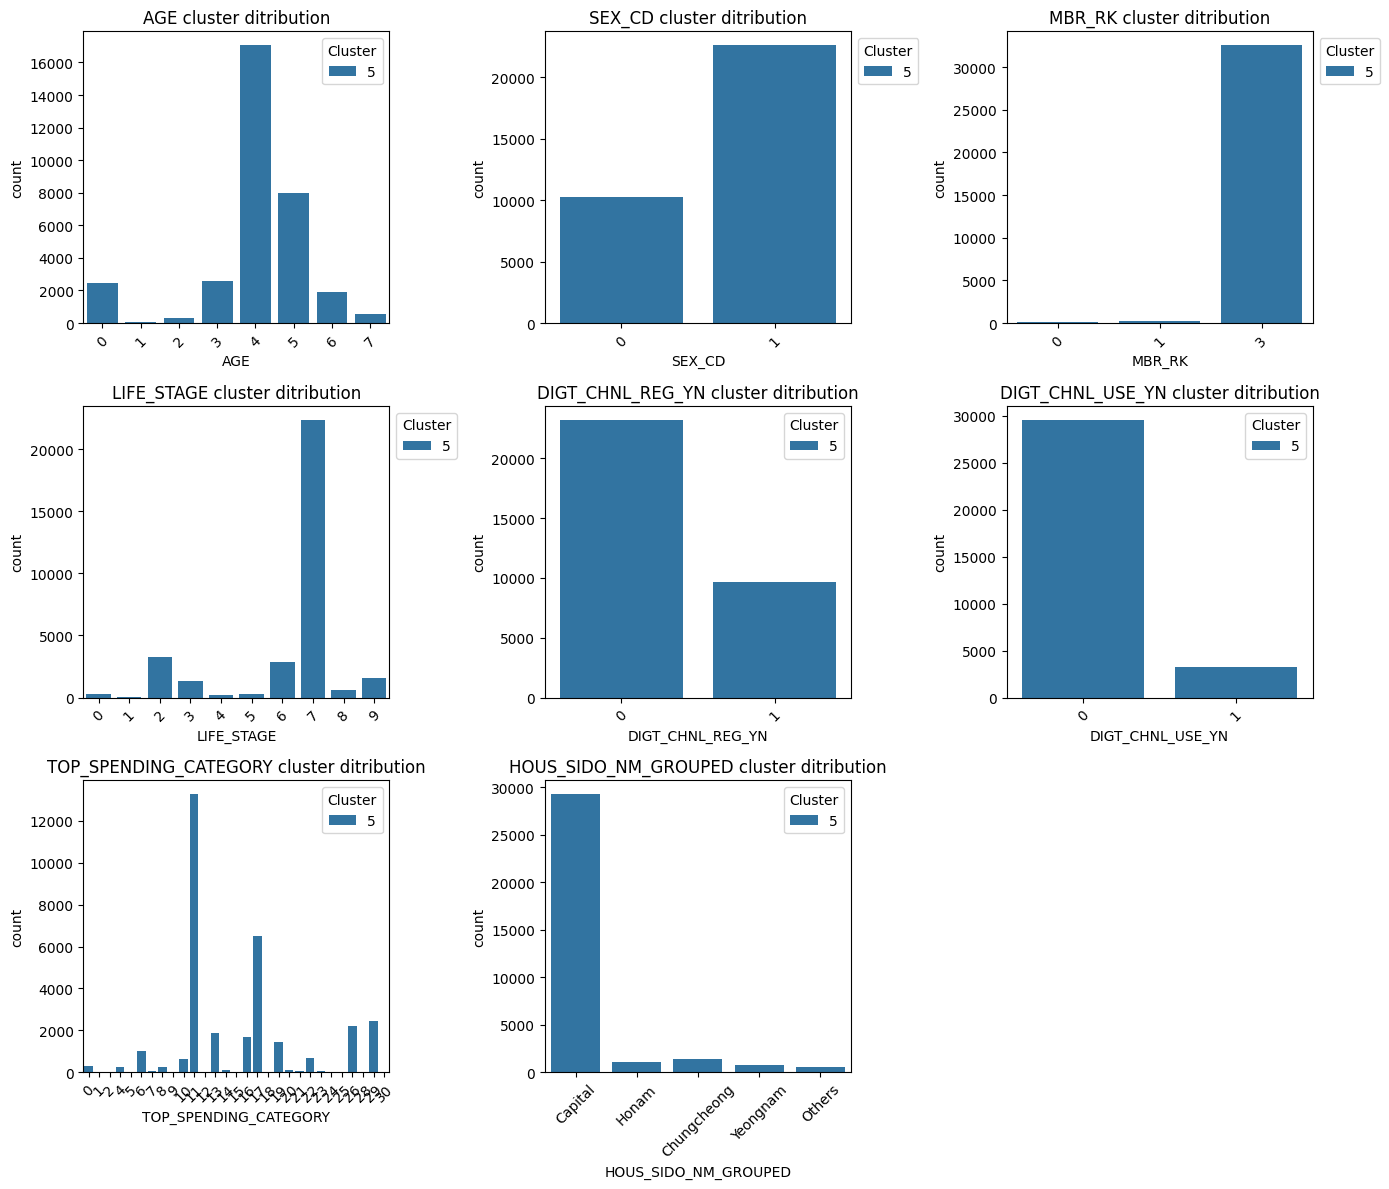


▶Cluster 6


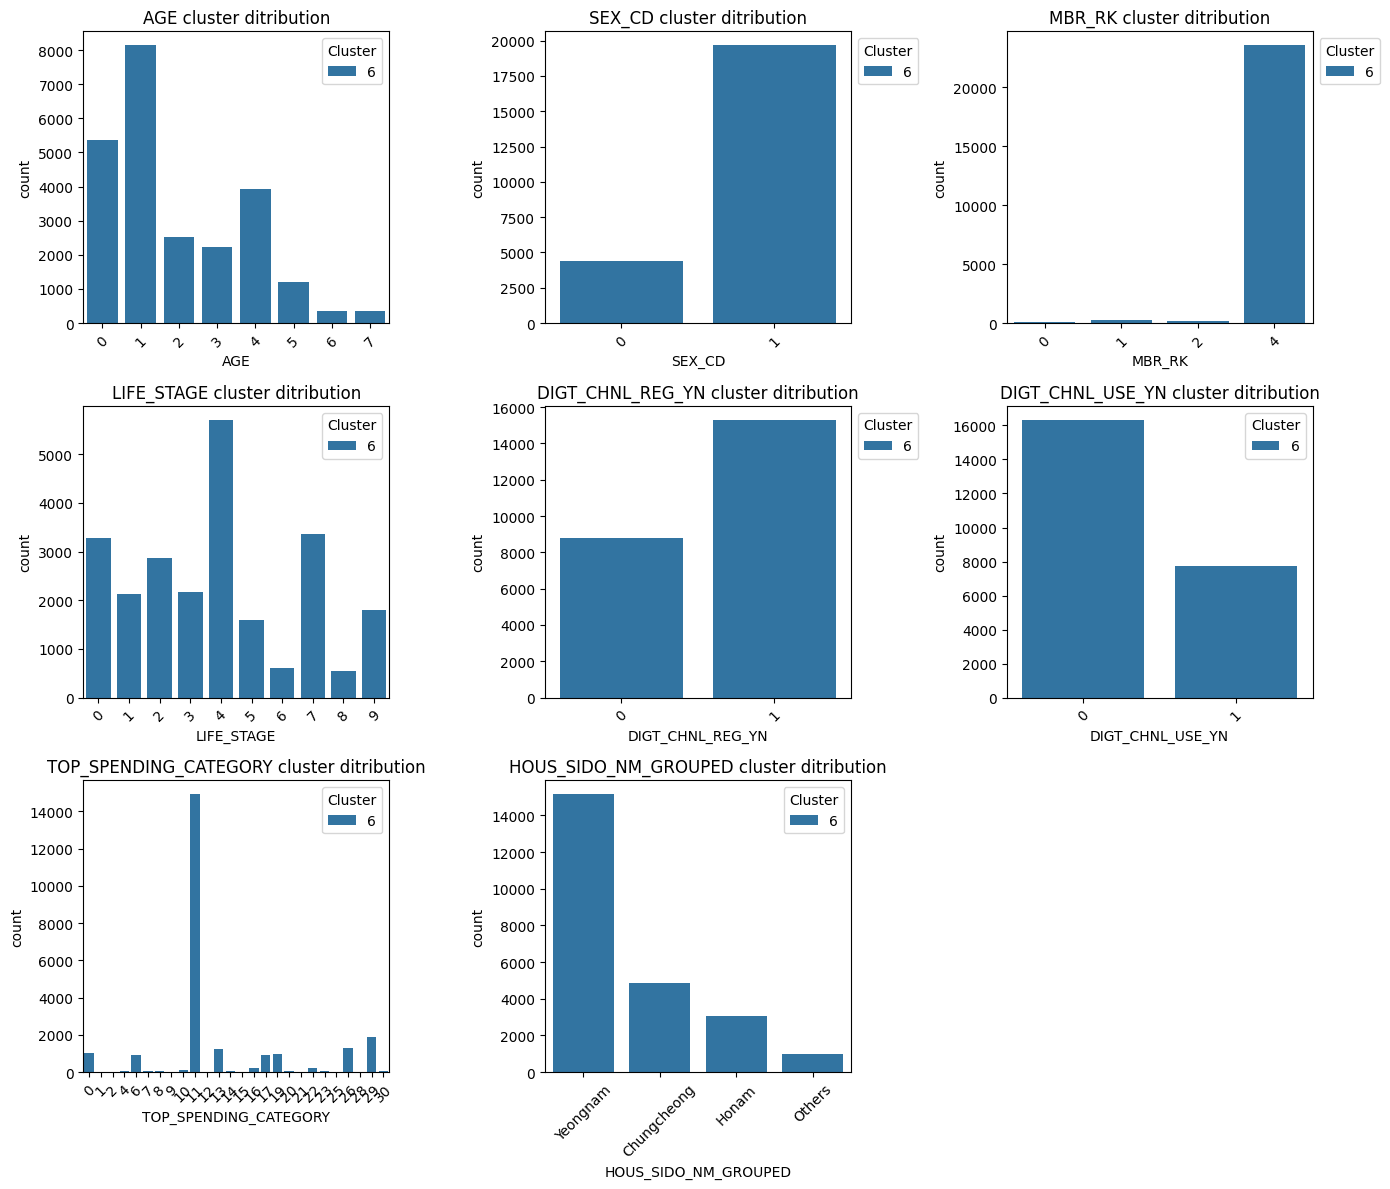


▶Cluster 7


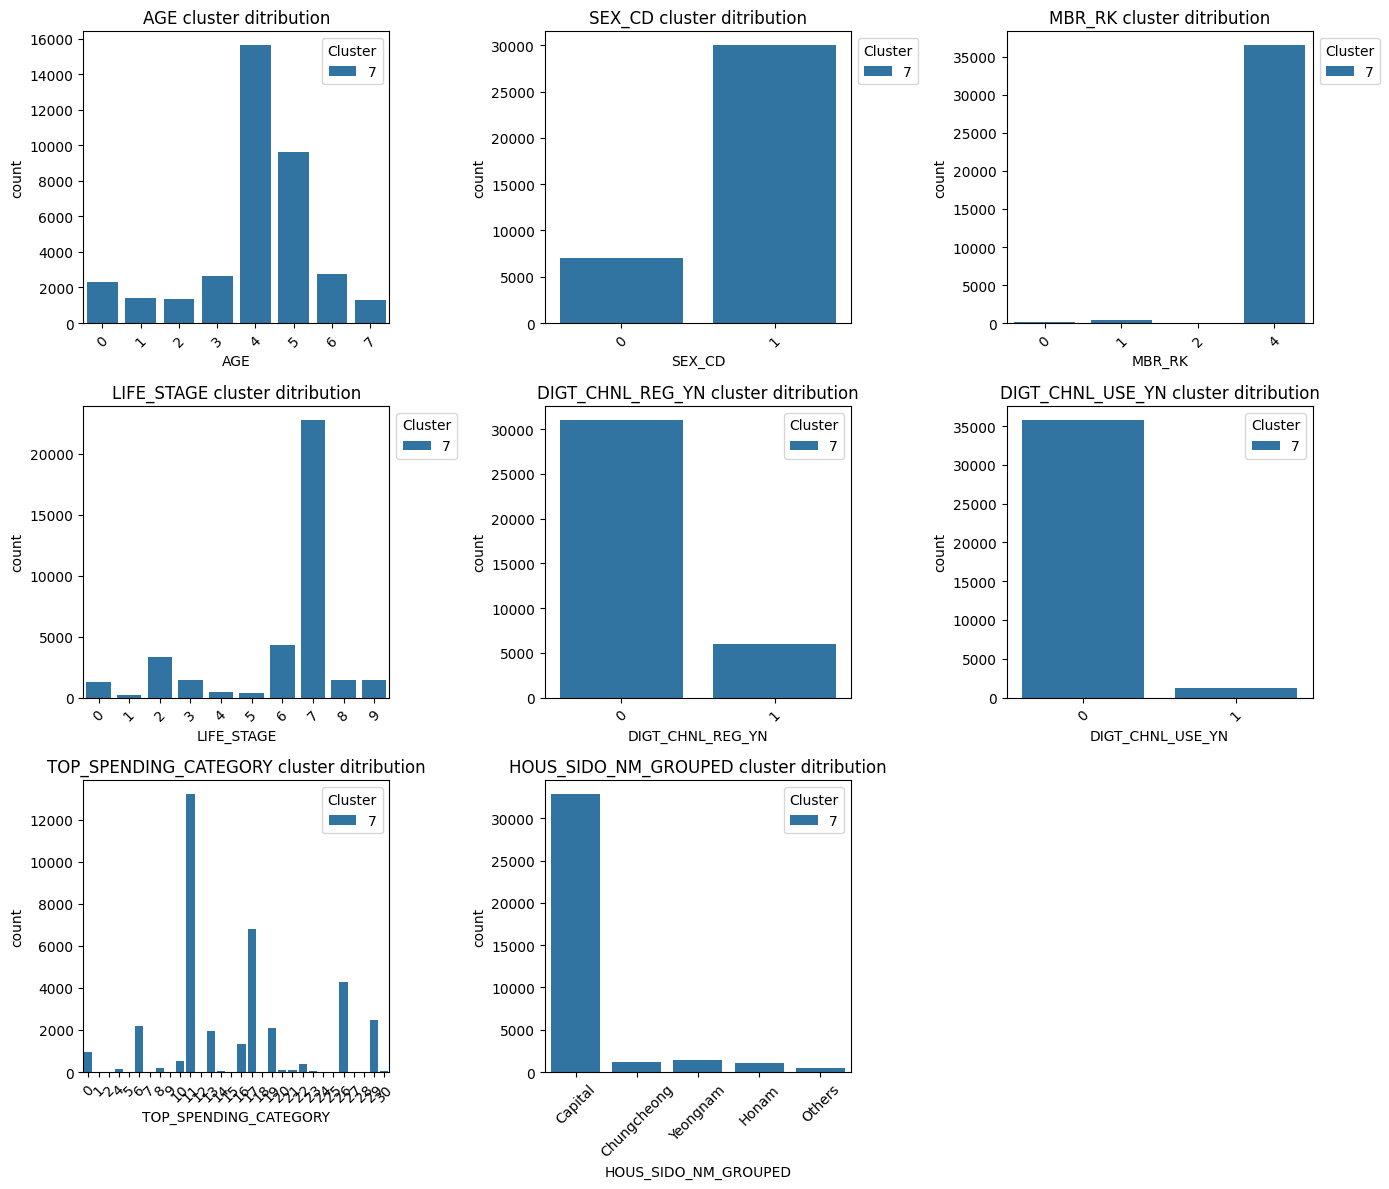


▶Cluster 8


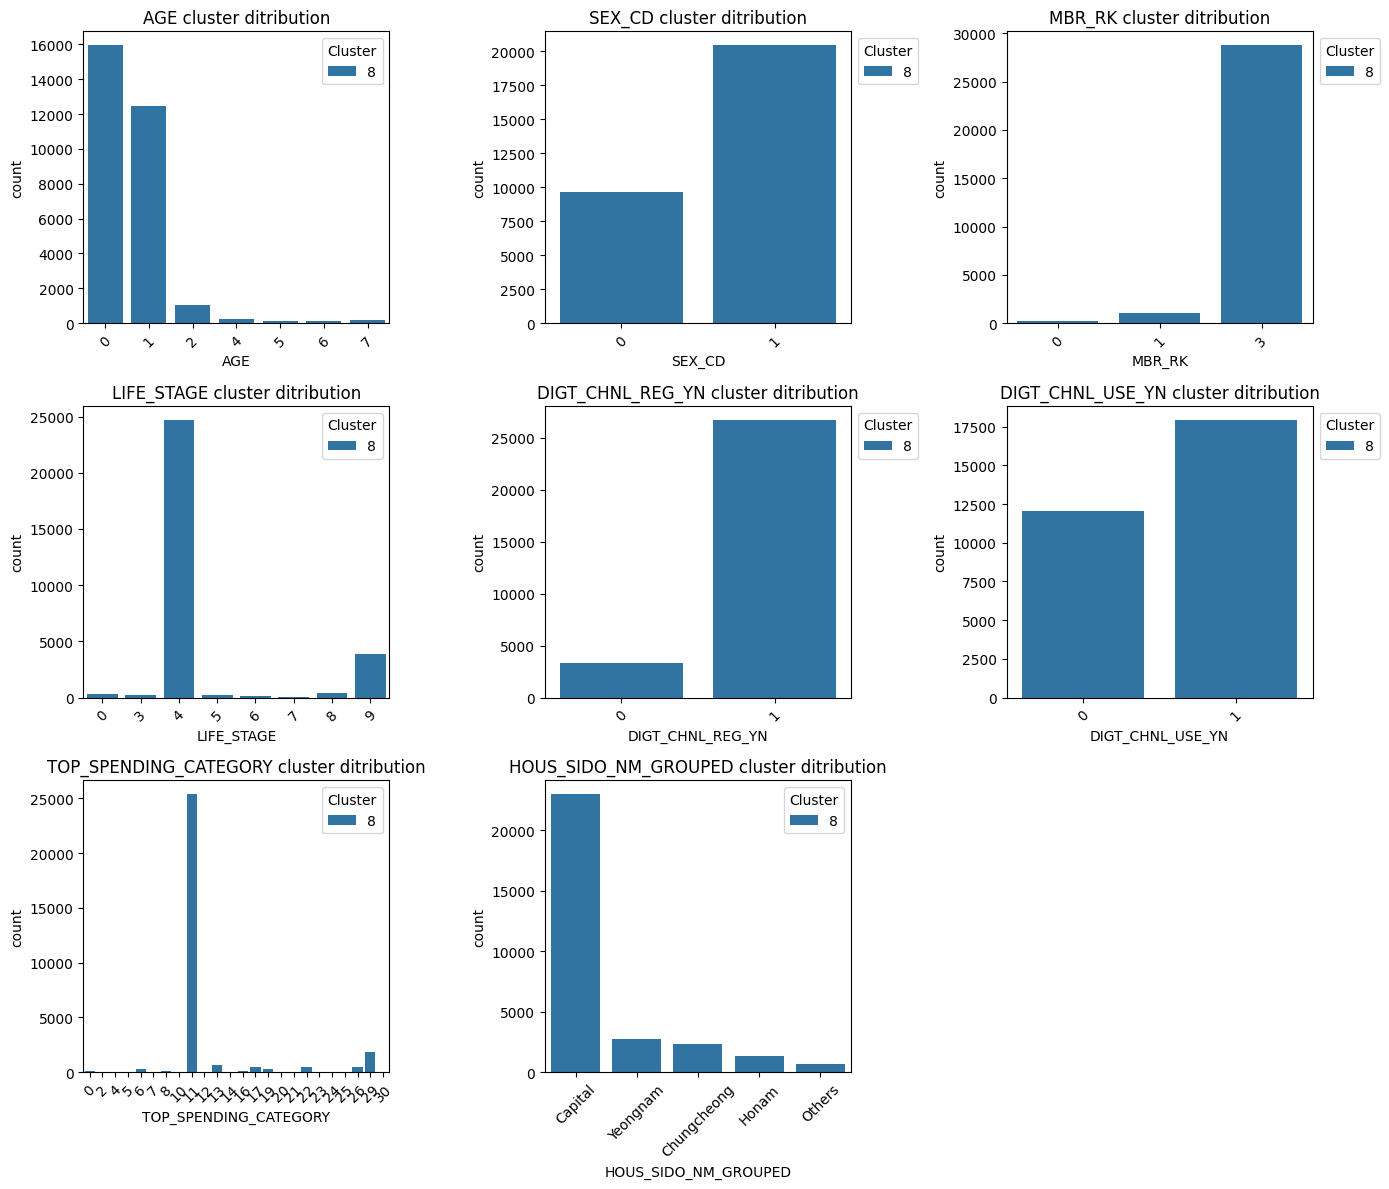


▶Cluster 9


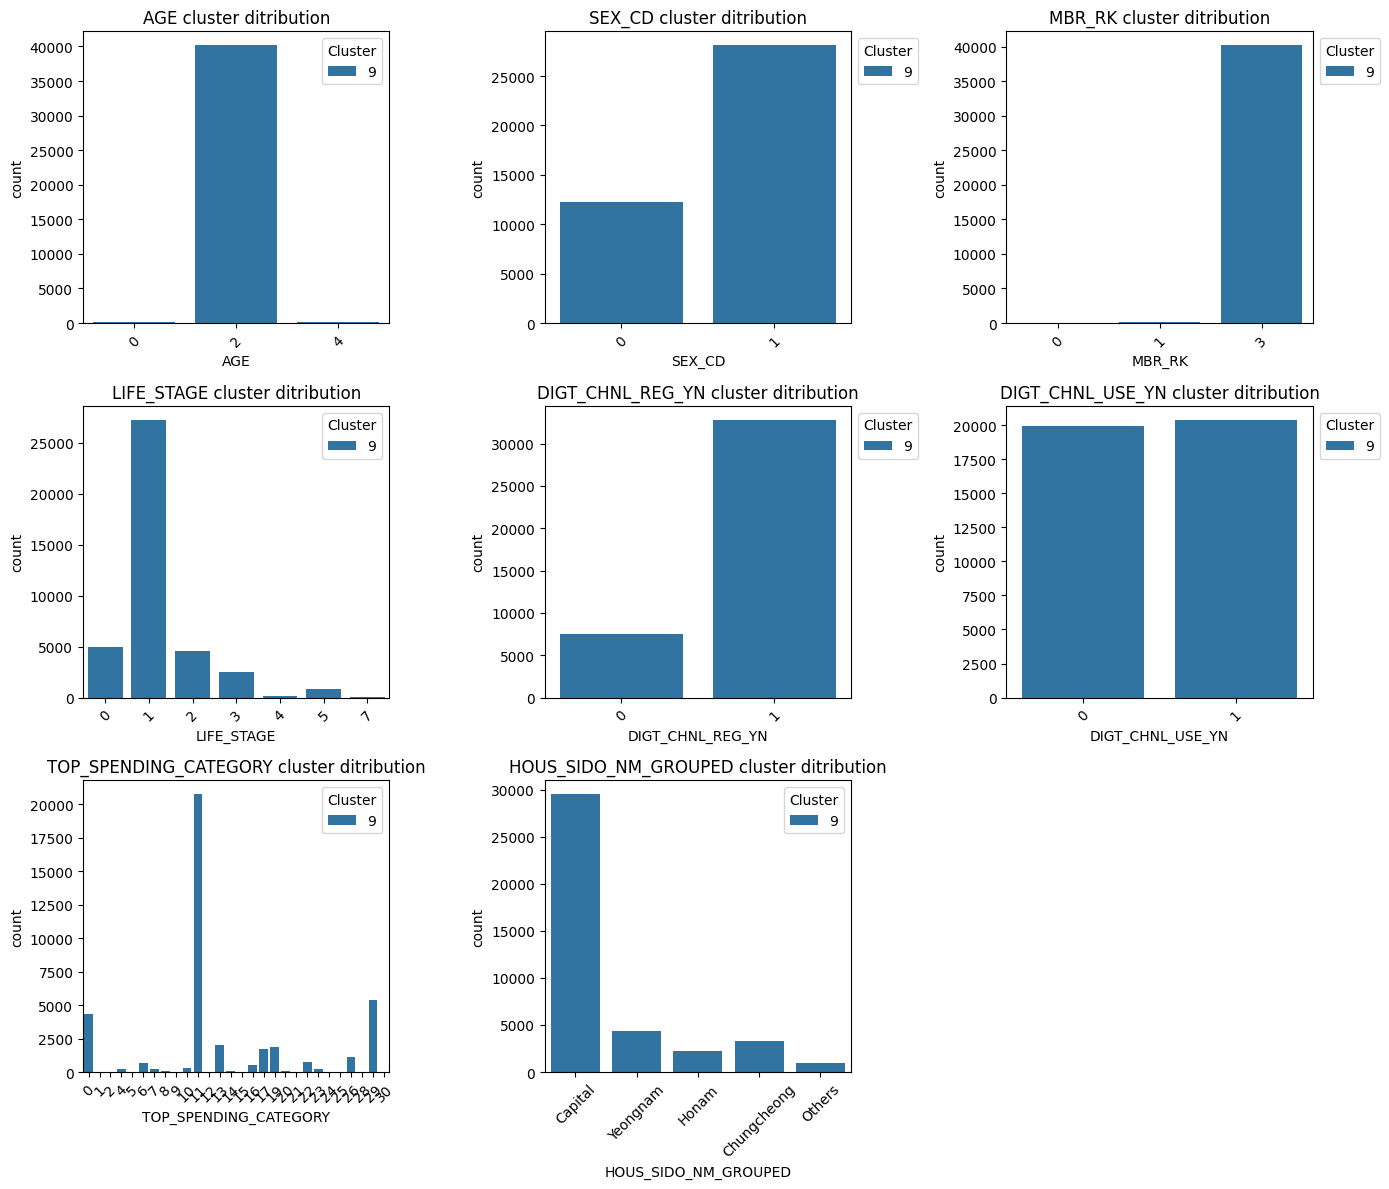


▶Cluster 10


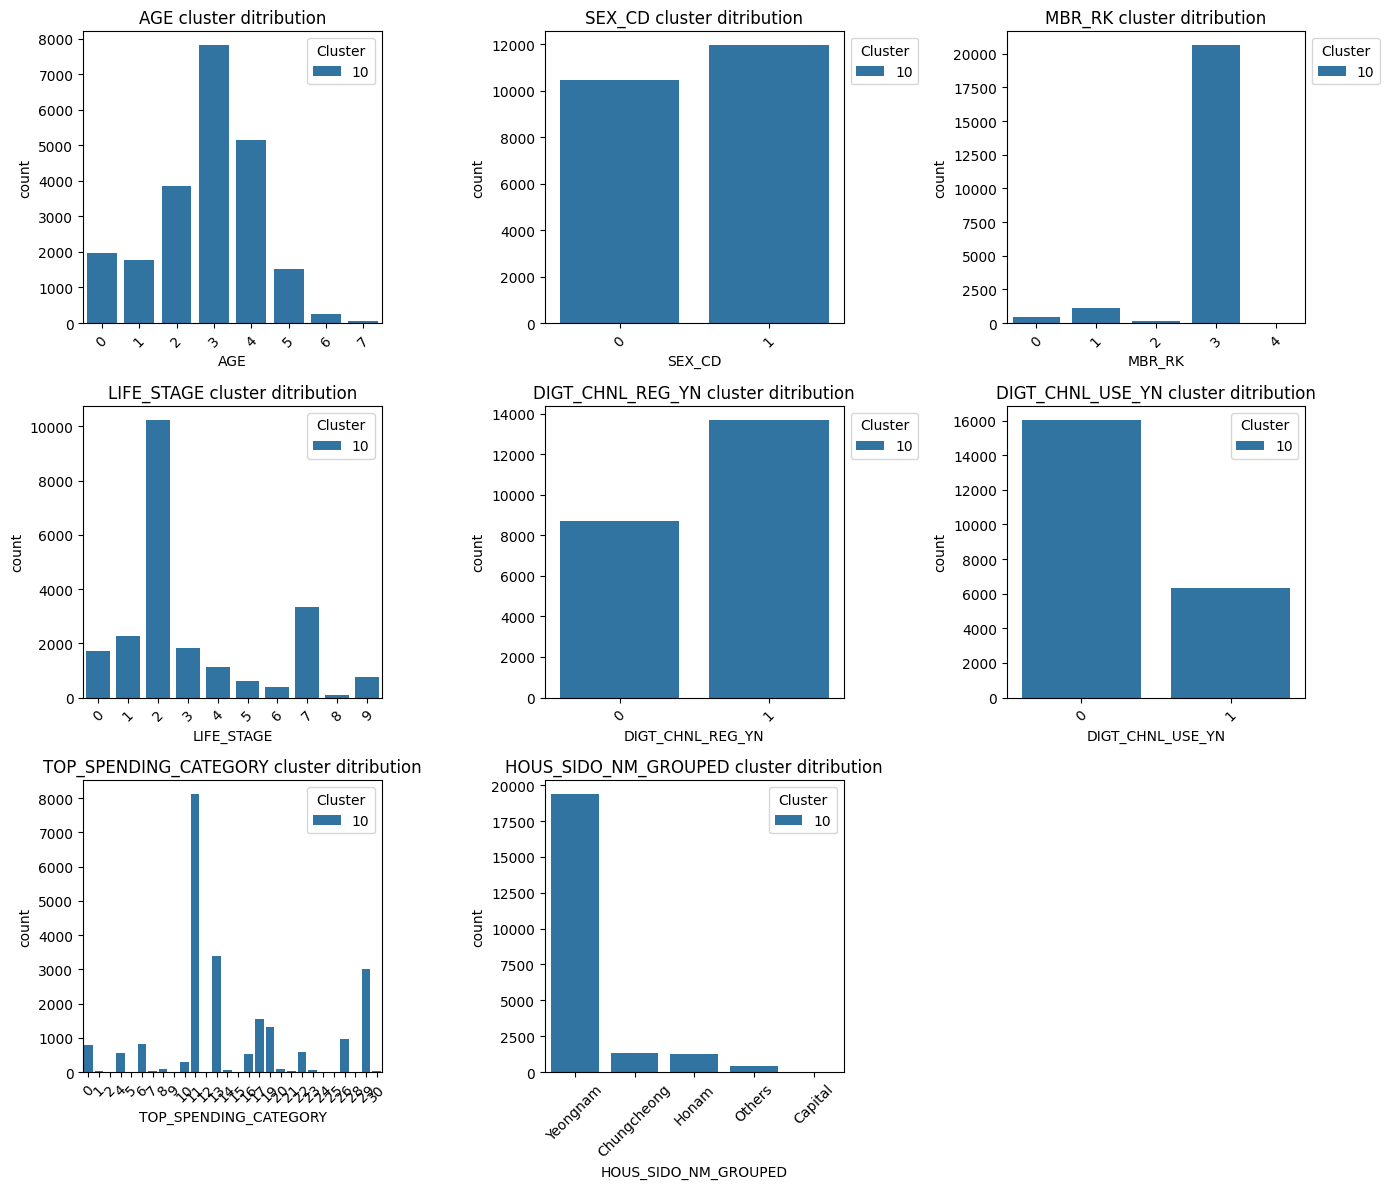


▶Cluster 11


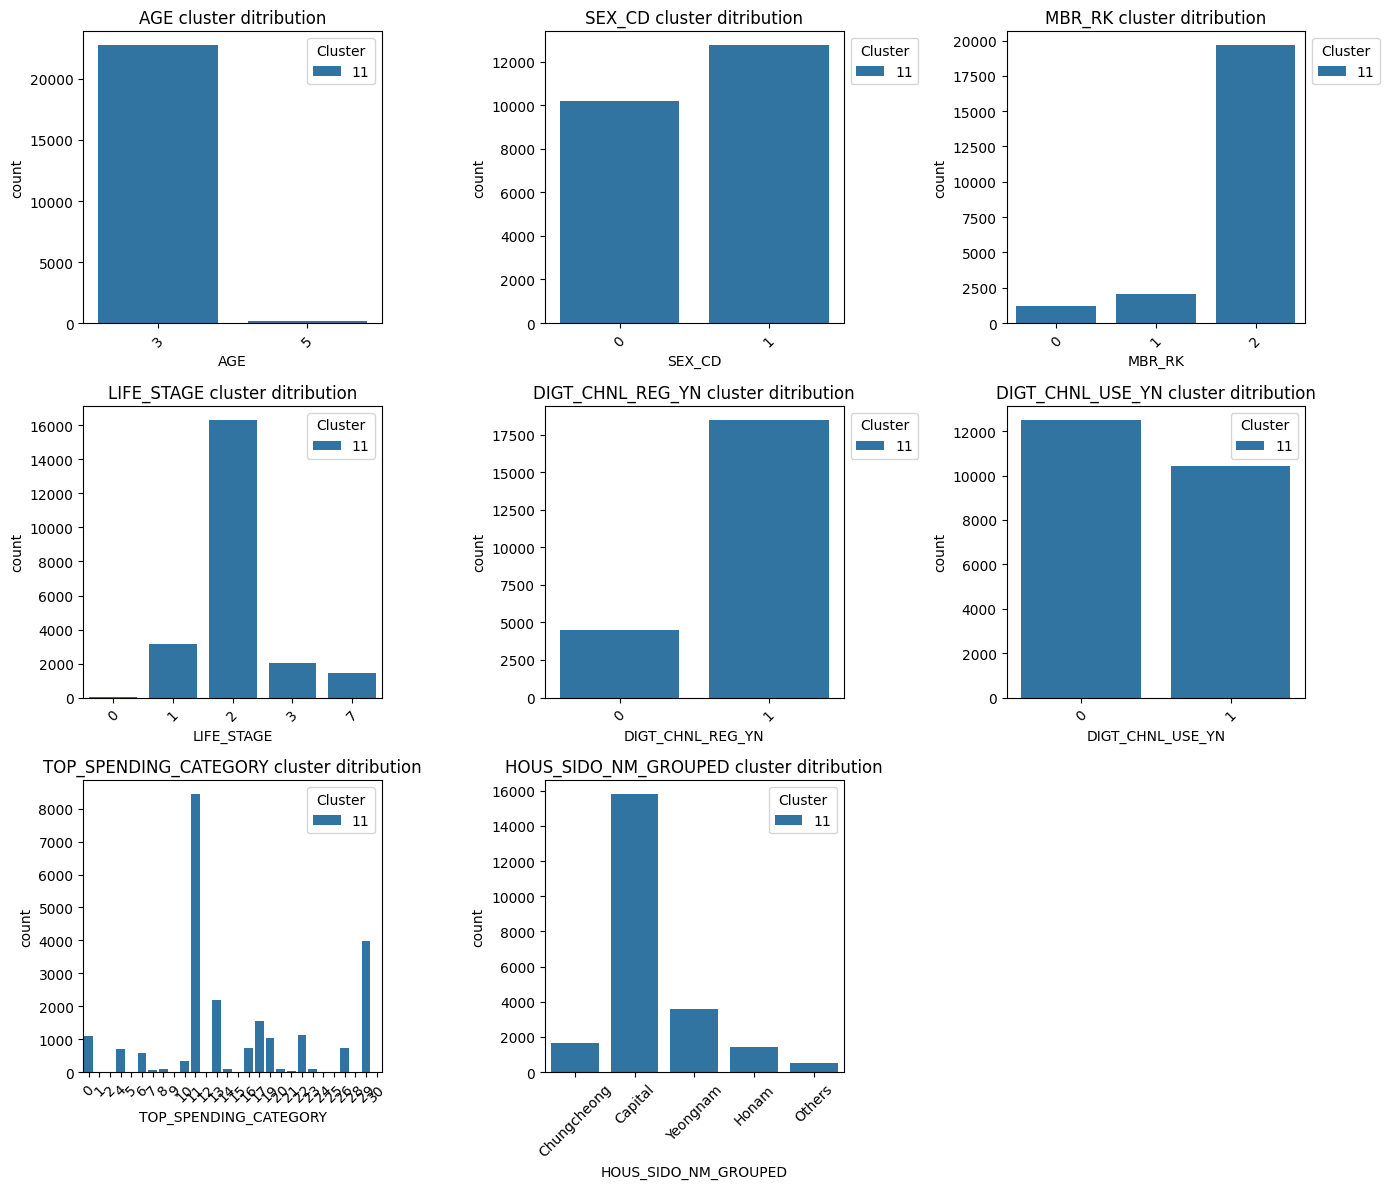


▶Cluster 12


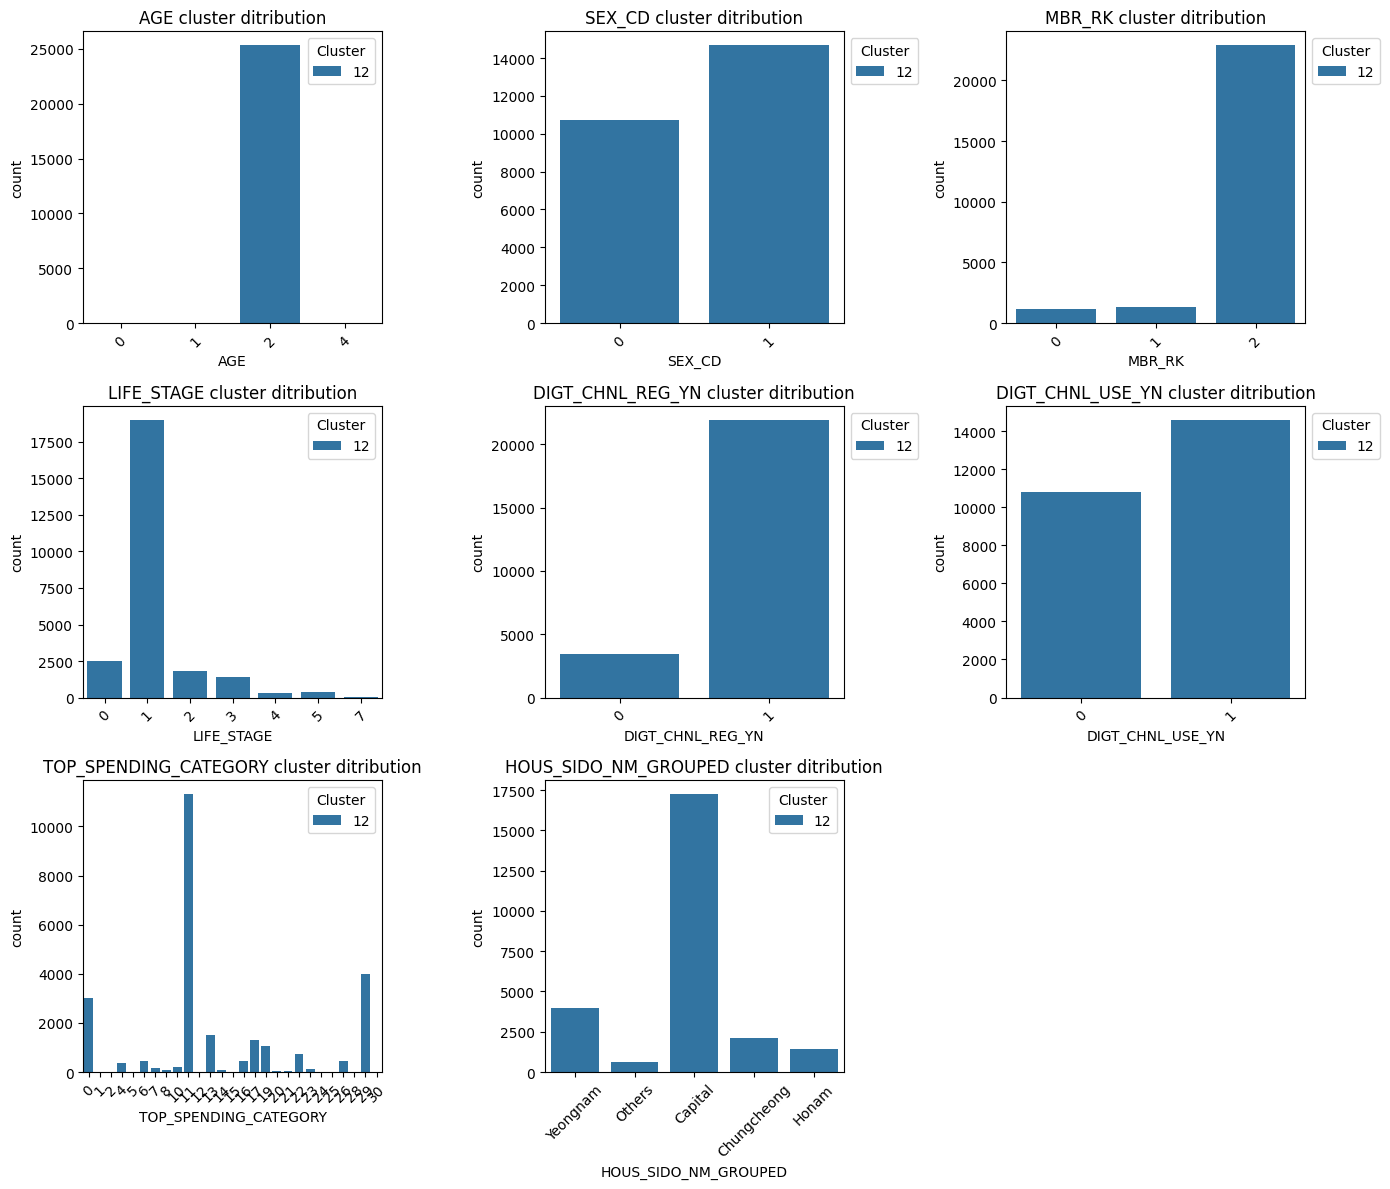


▶Cluster 13


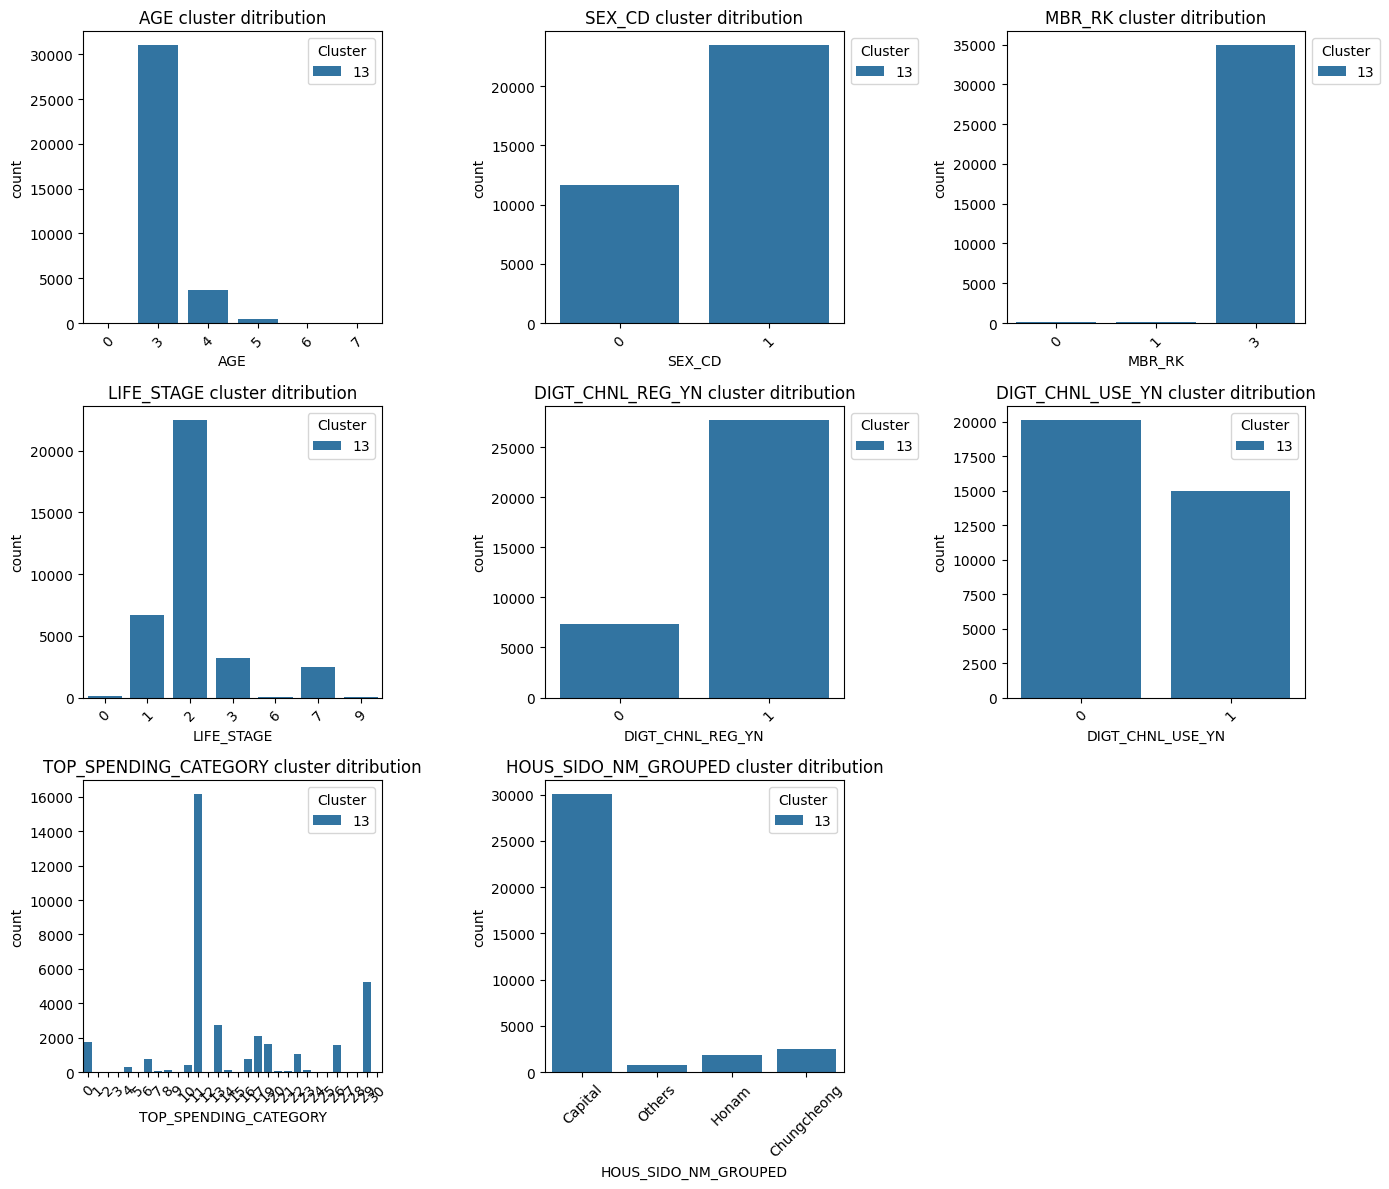


▶Cluster 14


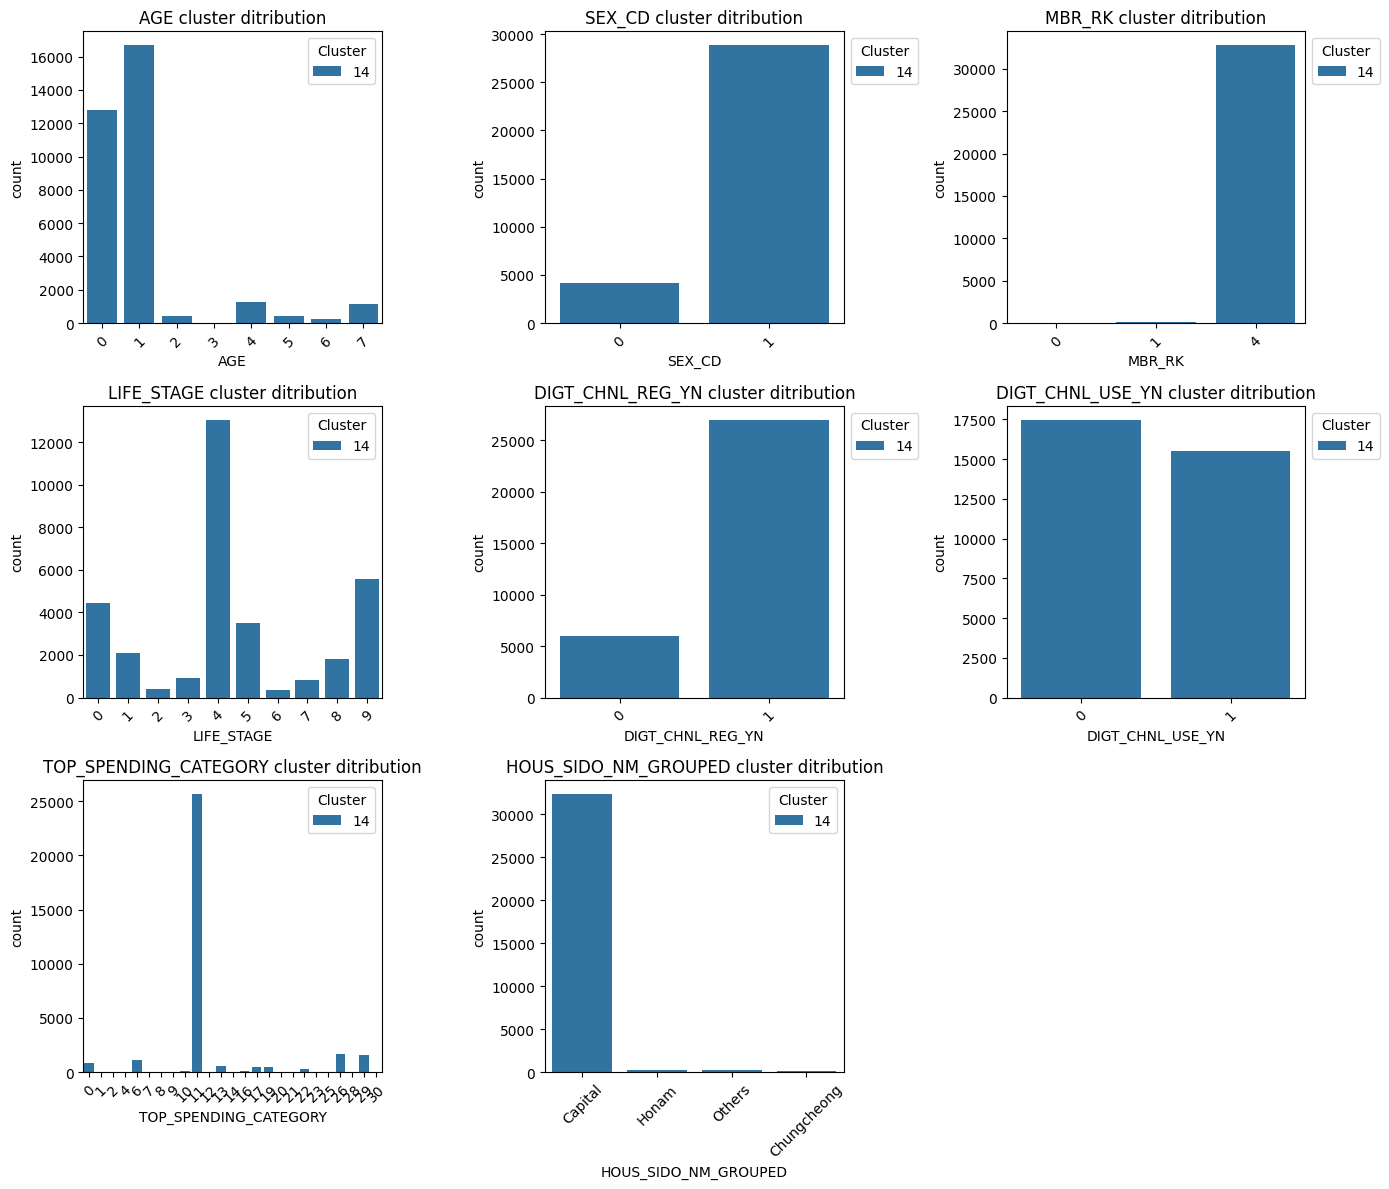


▶Cluster 15


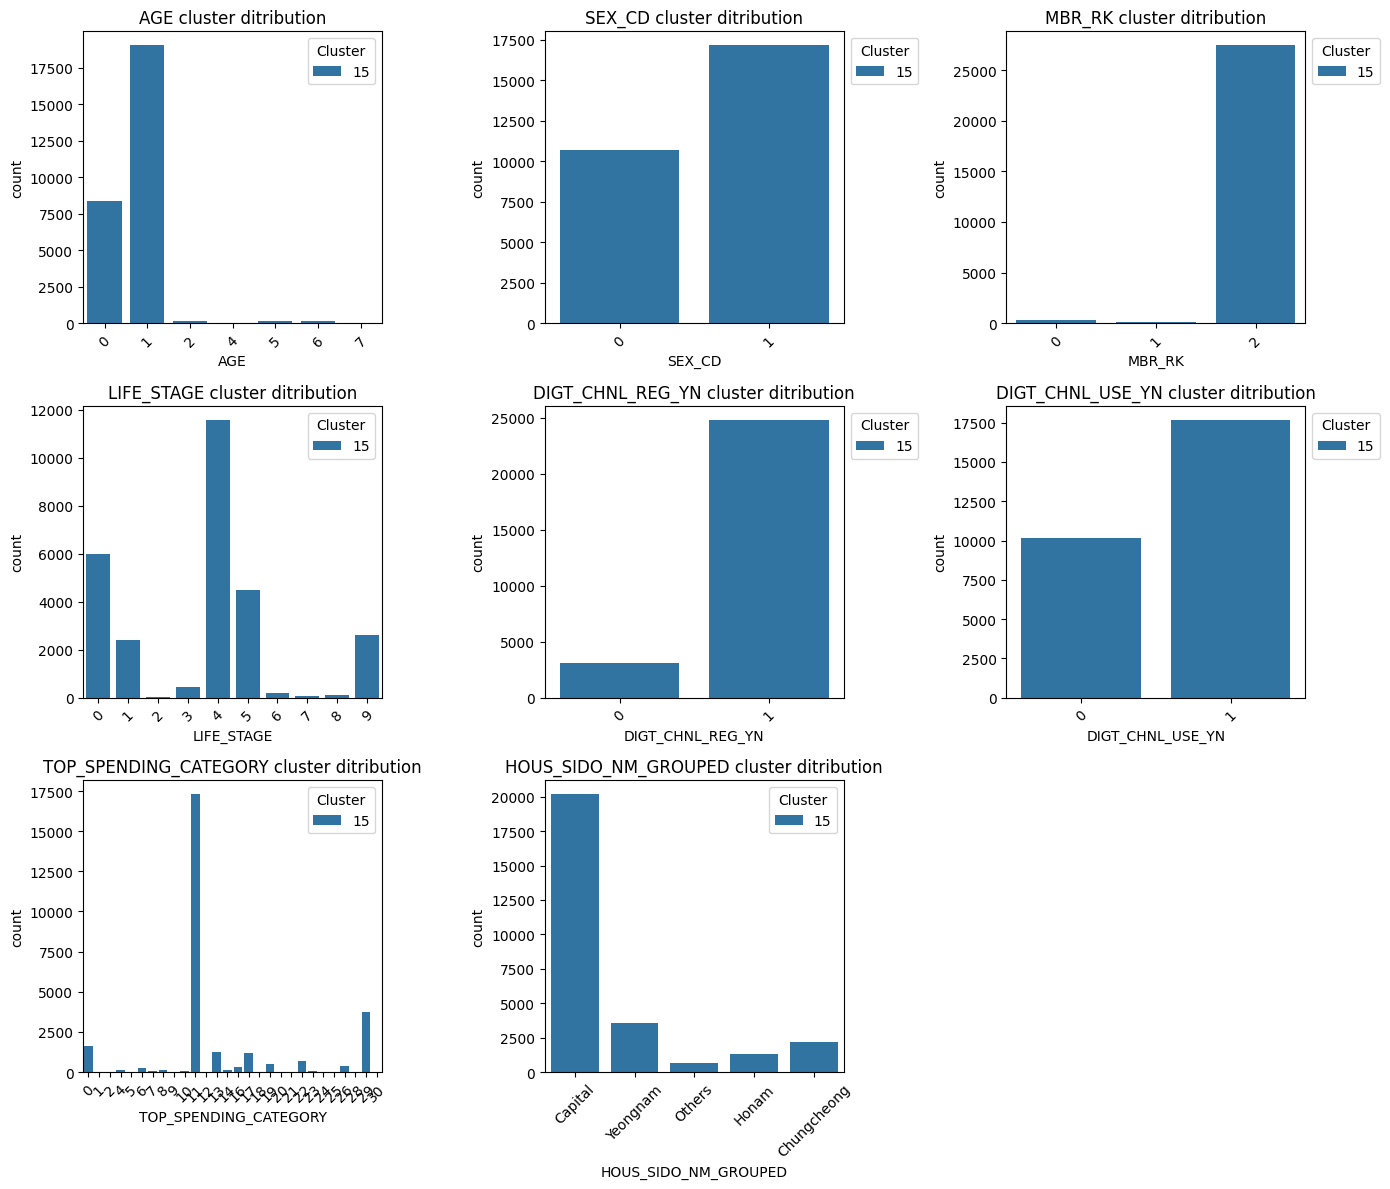

In [ ]:
for i in range(16):
    # cluster0
    cluster = features_copy[features_copy['cluster']==i]

    print("▶Cluster",i)
    plt.figure(figsize=(14, 12))
    for i, var in enumerate(categorical_vars, 1):
        plt.subplot(3, 3, i)
        sns.countplot(x=var, hue="cluster", data=cluster, palette="tab10")
        plt.title(f"{var} cluster ditribution")
        plt.xticks(rotation=45)
        plt.legend(title="Cluster", bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()
    print("")

### 수치형변수

<ipython-input-44-196cd6a06352>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="TOT_USE_AM_mean", data=features_copy, palette="Set2")


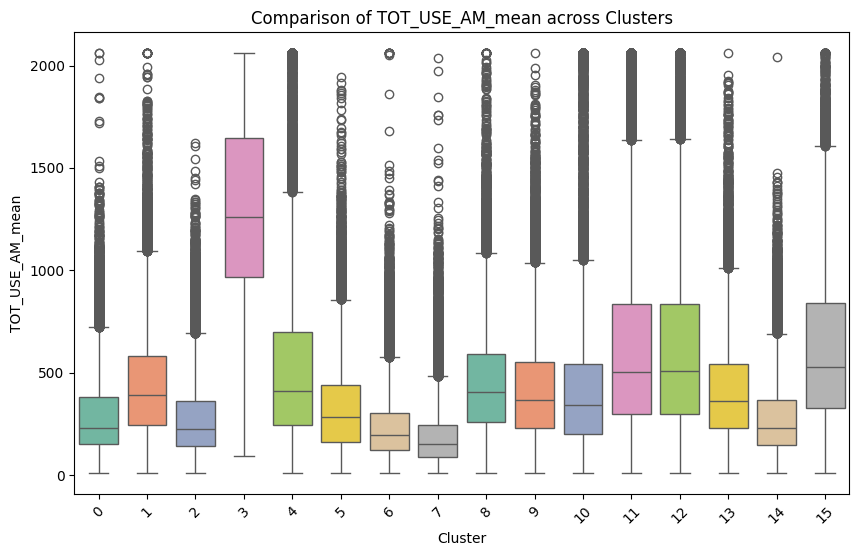

In [ ]:
plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(x="cluster", y="TOT_USE_AM_mean", data=features_copy, palette="Set2")

plt.title("Comparison of TOT_USE_AM_mean across Clusters")
plt.xlabel("Cluster")
plt.ylabel("TOT_USE_AM_mean")
plt.xticks(rotation=45)
plt.show()


In [ ]:
cluster_avg

cluster  TOT_USE_AM_mean
0         0       292.167022
1         1       438.318083
2         2       280.145192
3         3      1300.304400
4         4       528.607879
5         5       326.333151
6         6       242.202485
7         7       189.926258
8         8       450.413906
9         9       414.496025
10       10       421.809531
11       11       618.667385
12       12       610.900565
13       13       407.638153
14       14       284.518577
15       15       612.464078

<ipython-input-34-eef34bf8f851>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="cluster", y="TOT_USE_AM_mean", data=cluster_avg, palette="viridis")


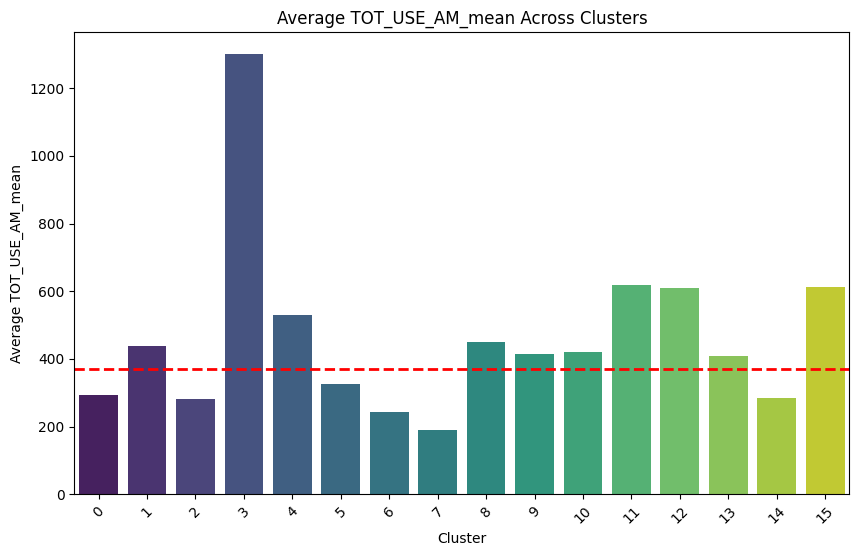

In [ ]:
# 클러스터별 평균값 계산
cluster_avg = features_copy.groupby("cluster")["TOT_USE_AM_mean"].mean().reset_index()

plt.figure(figsize=(10, 6))

# Barplot (클러스터별 평균 비교)
sns.barplot(x="cluster", y="TOT_USE_AM_mean", data=cluster_avg, palette="viridis")
plt.axhline(y=370, color='red', linestyle='--', linewidth=2, label='y = 370')

plt.title("Average TOT_USE_AM_mean Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Average TOT_USE_AM_mean")
plt.xticks(rotation=45)
plt.show()


In [ ]:
features_copy.describe()

AGE         SEX_CD         MBR_RK     LIFE_STAGE  \
count  459543.000000  459543.000000  459543.000000  459543.000000   
mean        2.336029       0.705314       2.931739       3.280011   
std         1.503732       0.455902       0.979349       2.590697   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       2.000000       1.000000   
50%         2.000000       1.000000       3.000000       2.000000   
75%         3.000000       1.000000       4.000000       5.000000   
max         7.000000       1.000000       4.000000       9.000000   

       DIGT_CHNL_REG_YN  DIGT_CHNL_USE_YN  TOT_USE_AM_mean  CRDSL_USE_AM_mean  \
count     459543.000000     459543.000000    459543.000000      459543.000000   
mean           0.700030          0.412022       448.380307         327.849450   
std            0.458245          0.492200       381.287424         364.889893   
min            0.000000          0.000000         8.750000           0.000000   
25%            0.000000          0.000000       187.500000          52.500000   
50%            1.000000          0.000000       335.000000         222.500000   
75%            1.000000          1.000000       583.750000         456.250000   
max            1.000000          1.000000      2060.000000        1870.000000   

       CNF_USE_AM_mean  INTERIOR_AM_mean  INSUHOS_AM_mean  OFFEDU_AM_mean  \
count    459543.000000     459543.000000     459543.00000   459543.000000   
mean        109.049991          1.664559         41.94666       10.857014   
std         177.822413          4.279603         55.45608       34.445237   
min           0.000000          0.000000          0.00000        0.000000   
25%           0.000000          0.000000          2.50000        0.000000   
50%           0.000000          0.000000         21.25000        0.000000   
75%         165.000000          1.250000         58.75000        1.250000   
max         820.000000         40.000000        380.00000      210.000000   

       TRVLEC_AM_mean   FSBZ_AM_mean  SVCARC_AM_mean   DIST_AM_mean  \
count   459543.000000  459543.000000   459543.000000  459543.000000   
mean        16.101458      67.932908       21.113459     174.013719   
std         26.899185      73.086944       33.373836     174.806279   
min          0.000000       0.000000        0.000000       0.000000   
25%          0.000000      13.750000        0.000000      51.250000   
50%          5.000000      43.750000        5.000000     120.000000   
75%         20.000000      97.500000       30.000000     236.250000   
max        180.000000     360.000000      200.000000     910.000000   

       PLSANIT_AM_mean  CLOTHGDS_AM_mean   AUTO_AM_mean  FUNITR_AM_mean  \
count    459543.000000     459543.000000  459543.000000   459543.000000   
mean          5.067747          3.612113      23.806532        0.967809   
std           9.153851          7.154692      50.871063       11.695651   
min           0.000000          0.000000       0.000000        0.000000   
25%           0.000000          0.000000       0.000000        0.000000   
50%           1.250000          0.000000       1.250000        0.000000   
75%           6.250000          3.750000      23.750000        0.000000   
max          70.000000         60.000000     300.000000     3601.250000   

       APPLNC_AM_mean  HLTHFS_AM_mean  BLDMNG_AM_mean  ARCHIT_AM_mean  \
count   459543.000000        459543.0   459543.000000   459543.000000   
mean         0.467146             0.0        6.512062        0.142364   
std          1.587140             0.0       13.589650        0.710507   
min          0.000000             0.0        0.000000        0.000000   
25%          0.000000             0.0        0.000000        0.000000   
50%          0.000000             0.0        0.000000        0.000000   
75%          0.000000             0.0        7.500000        0.000000   
max         20.000000             0.0       90.000000       10.000000  

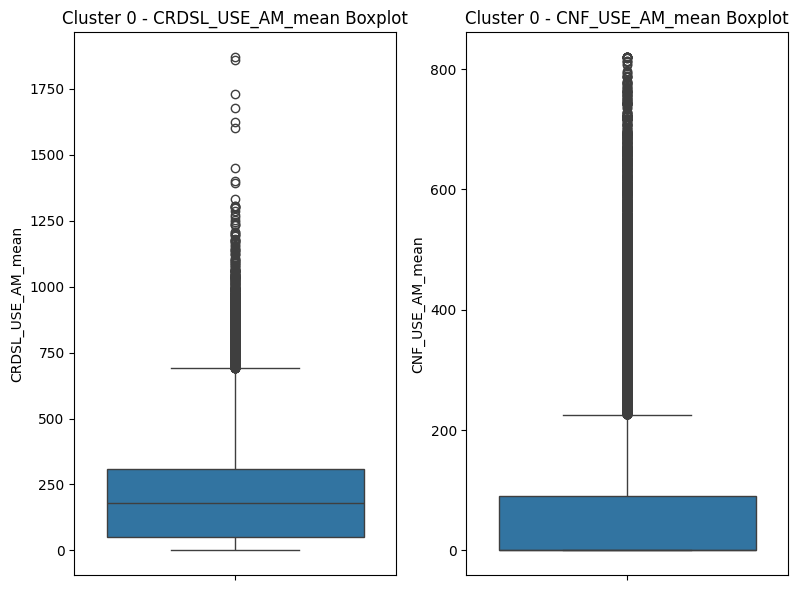

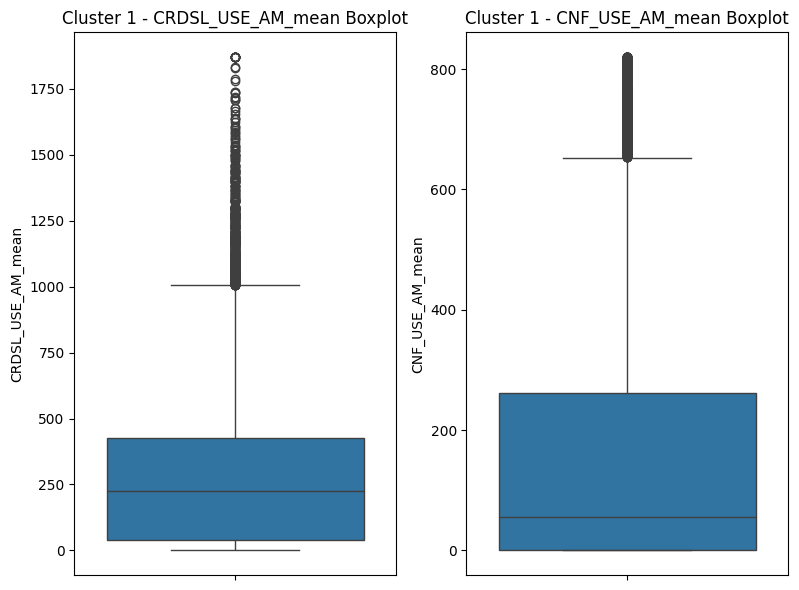

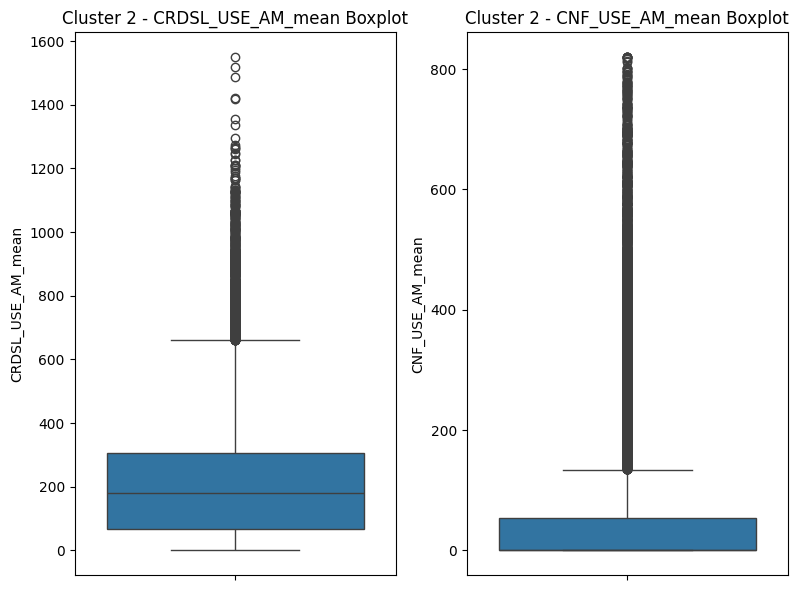

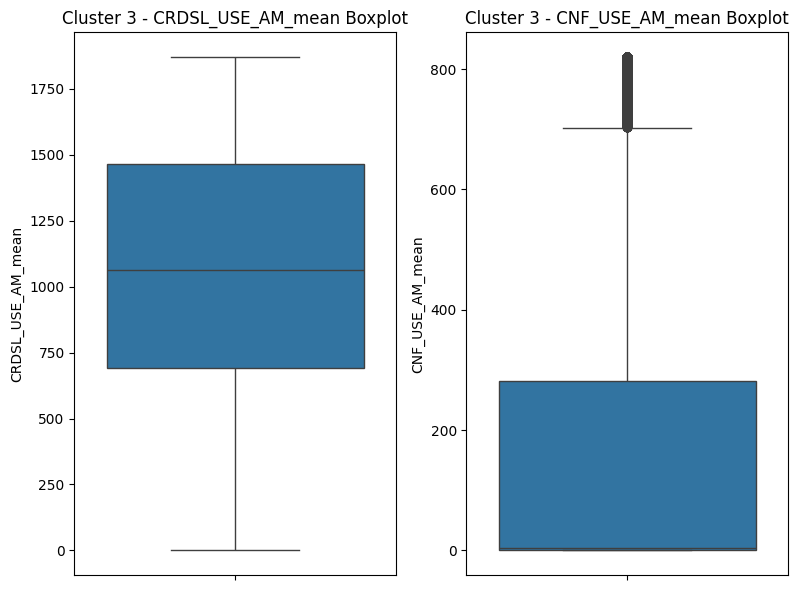

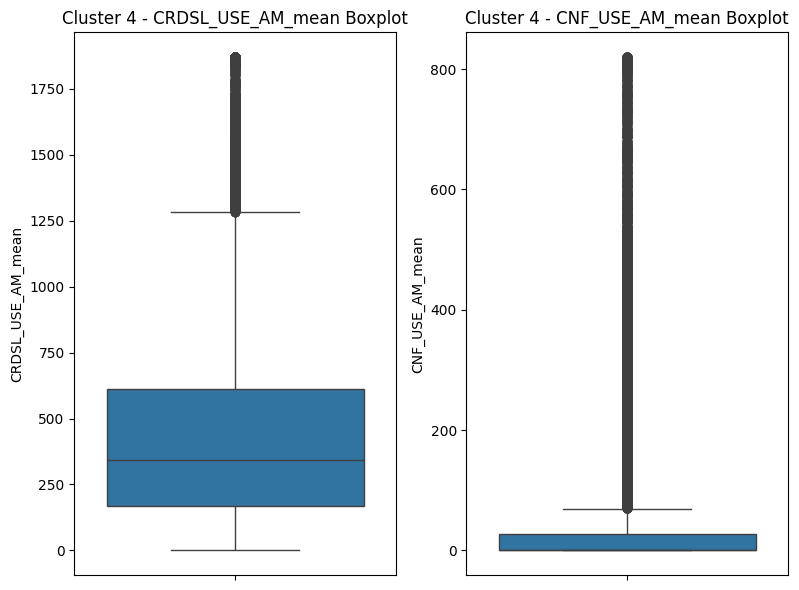

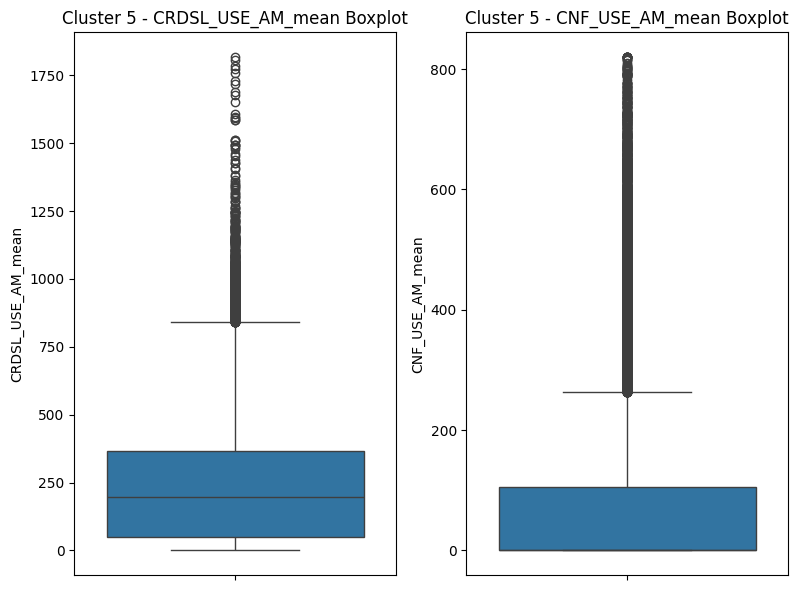

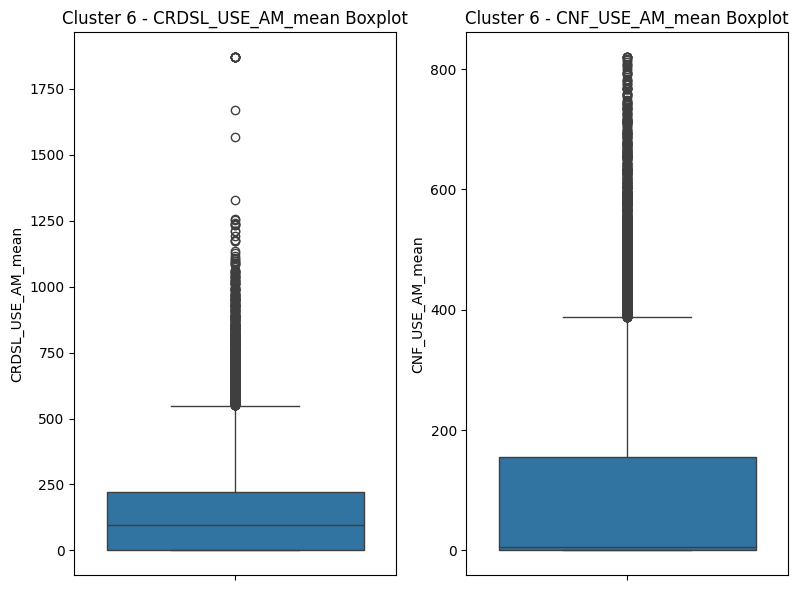

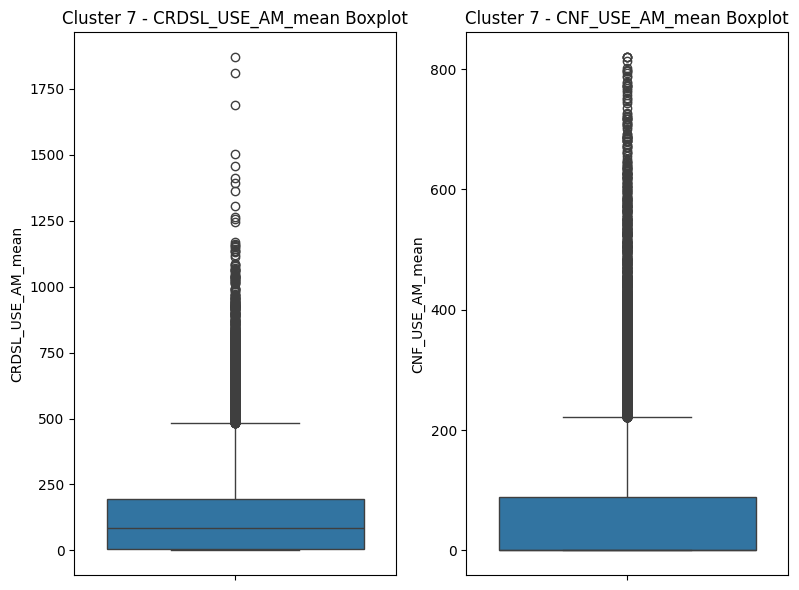

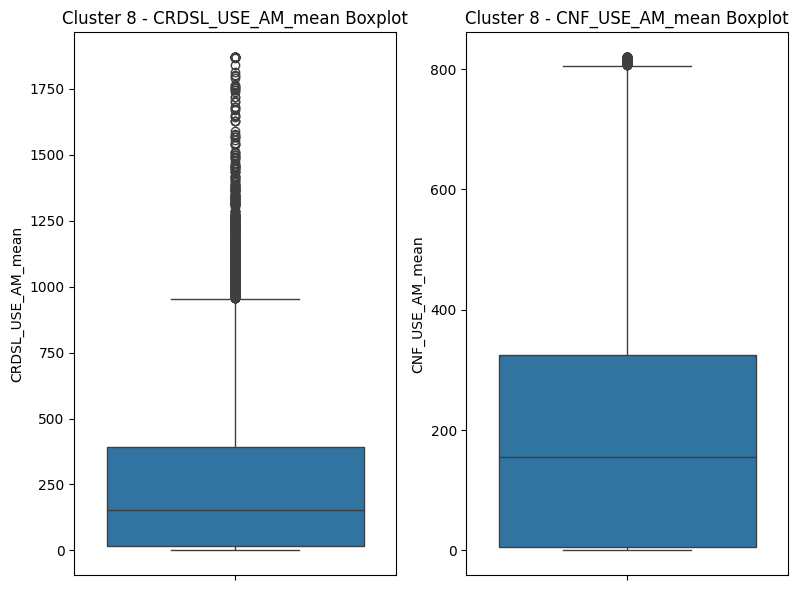

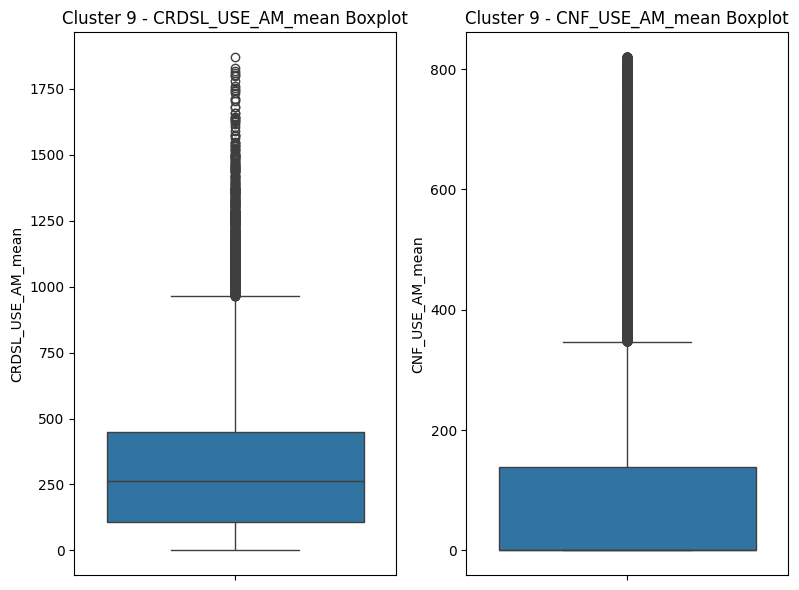

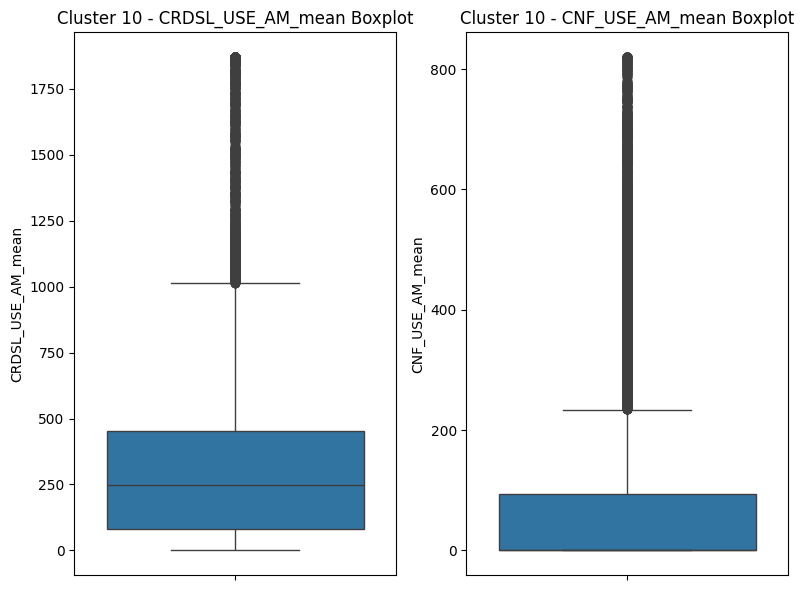

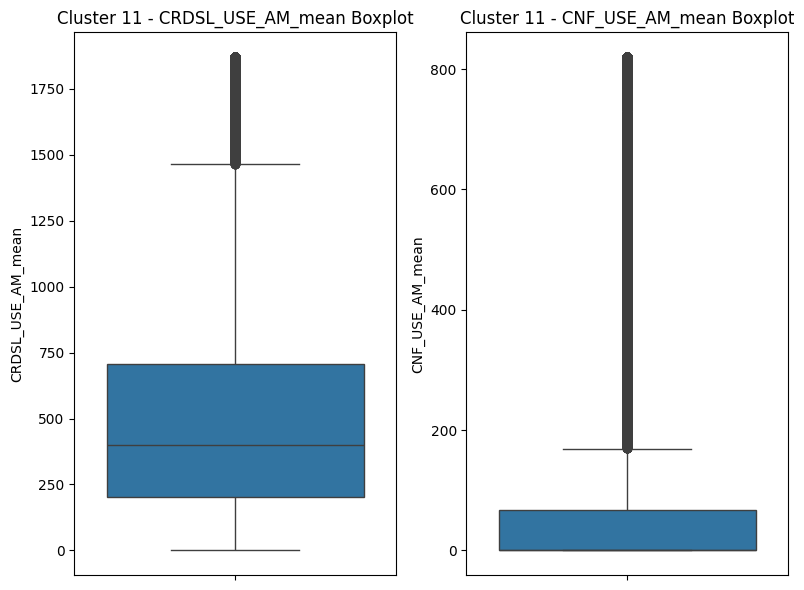

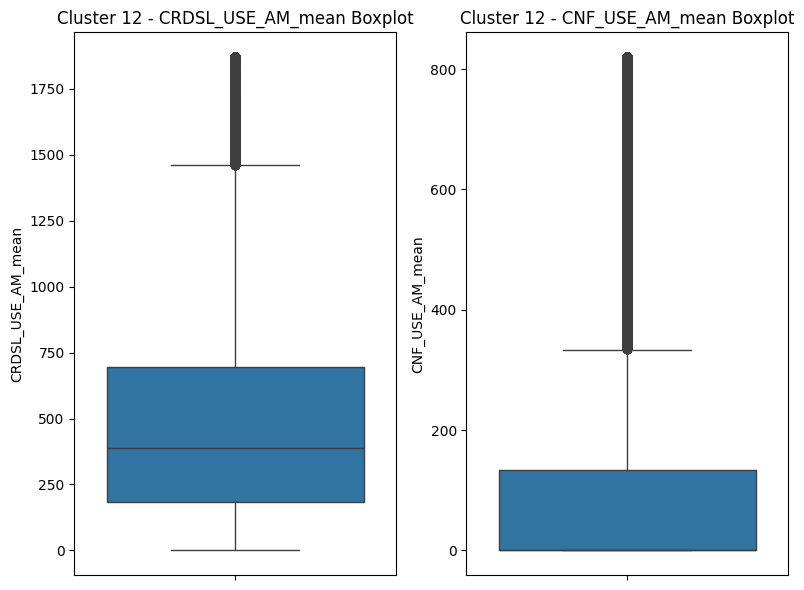

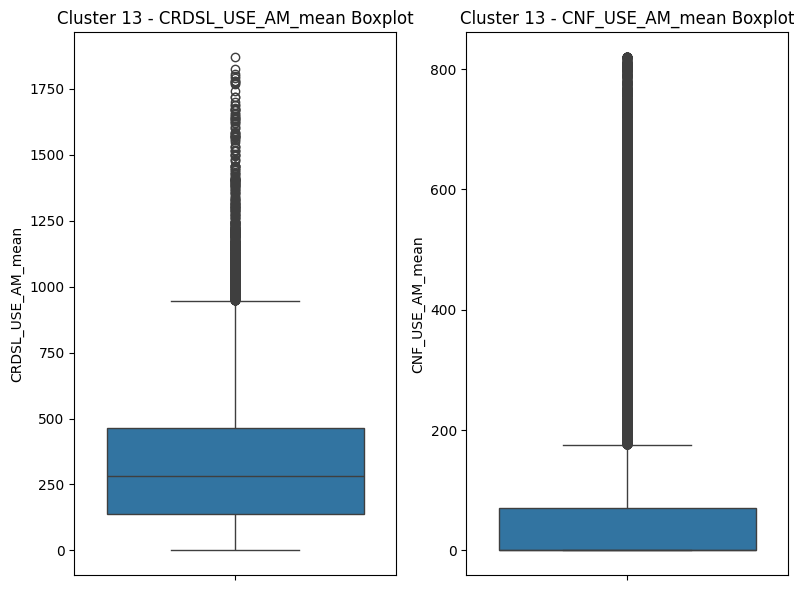

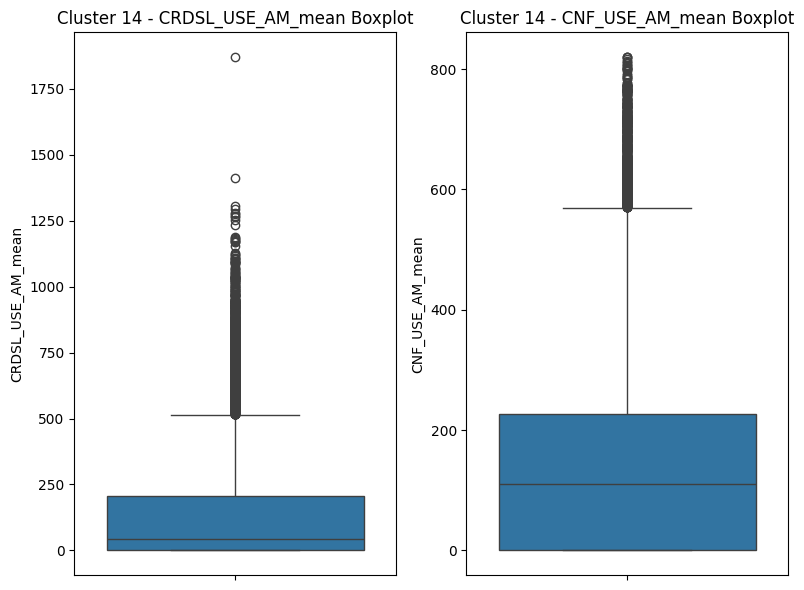

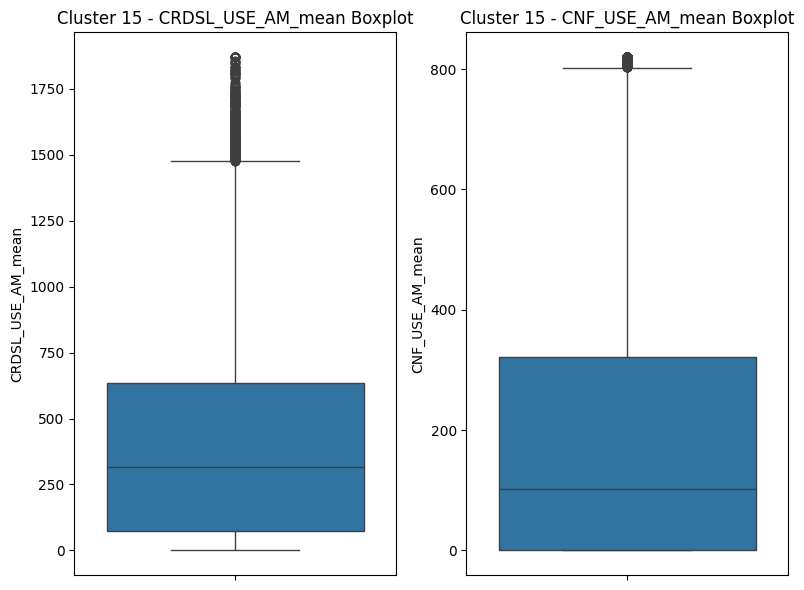

In [ ]:
numerical_vars = ["CRDSL_USE_AM_mean", "CNF_USE_AM_mean"]
for cluster_num in range(16):
    cluster = features_copy[features_copy['cluster'] == cluster_num]

    plt.figure(figsize=(12, 6))
    for i, var in enumerate(numerical_vars, 1):
        plt.subplot(1, 3, i)
        sns.boxplot(y=cluster[var])
        plt.title(f"Cluster {cluster_num} - {var} Boxplot")

    plt.tight_layout()
    plt.show()


### 군집 별 소비패턴

In [ ]:
numerical_vars = [
    'FUNITR_AM_mean', 'APPLNC_AM_mean',
    'HLTHFS_AM_mean', 'BLDMNG_AM_mean', 'ARCHIT_AM_mean', 'OPTIC_AM_mean', 'AGRICTR_AM_mean', 'LEISURE_S_AM_mean',
    'LEISURE_P_AM_mean', 'CULTURE_AM_mean', 'SANIT_AM_mean', 'INSU_AM_mean', 'OFFCOM_AM_mean', 'BOOK_AM_mean',
    'RPR_AM_mean', 'HOTEL_AM_mean', 'GOODS_AM_mean', 'TRVL_AM_mean', 'FUEL_AM_mean', 'SVC_AM_mean', 'DISTBNP_AM_mean',
    'DISTBP_AM_mean', 'GROCERY_AM_mean', 'HOS_AM_mean', 'CLOTH_AM_mean', 'RESTRNT_AM_mean', 'AUTOMNT_AM_mean',
    'AUTOSL_AM_mean', 'KITWR_AM_mean', 'FABRIC_AM_mean', 'ACDM_AM_mean', 'MBRSHOP_AM_mean'
]

In [ ]:
'''# 클러스터별 평균값 계산
cluster_means = features_copy.groupby("cluster")[numerical_vars].mean().reset_index()

# 반복문으로 클러스터별 시각화
for cluster_num in cluster_means["cluster"]:
    mean_values = cluster_means[cluster_means["cluster"] == cluster_num]

    plt.figure(figsize=(15, 6))

    # 바 차트 그리기
    sns.barplot(x=numerical_vars, y=mean_values.iloc[0, 1:], palette="viridis")

    # 제목 및 축 레이블 설정
    plt.title(f"Cluster {cluster_num} - Mean Comparison")
    plt.xticks(rotation=90)  # x축 레이블 가독성을 위해 회전
    plt.ylabel("Mean Value")
    plt.ylim(0, cluster_means[numerical_vars].max().max())  # y축을 전체 클러스터 기준으로 고정

    plt.show()'''

Cluster 0 - Top 5 Features:
['DISTBP_AM_mean', 'RESTRNT_AM_mean', 'SVC_AM_mean', 'ACDM_AM_mean', 'HOS_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


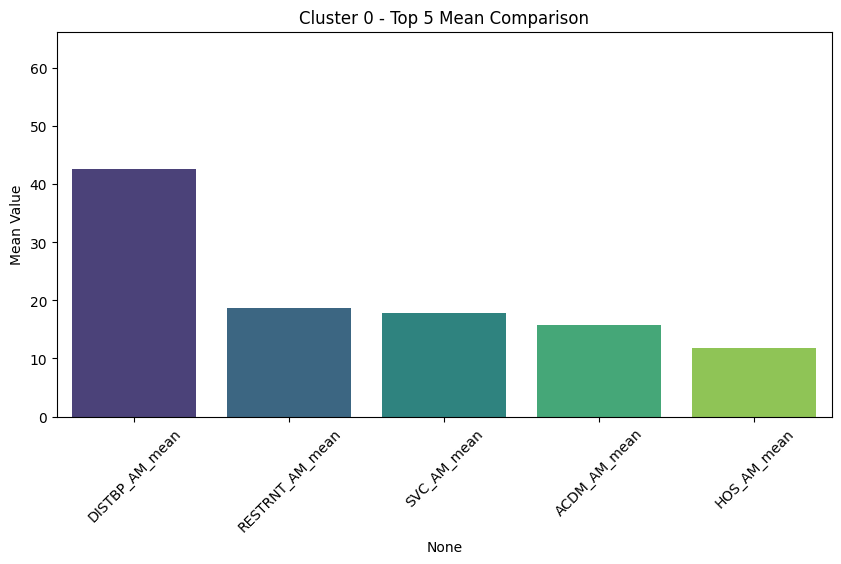

Cluster 1 - Top 5 Features:
['DISTBP_AM_mean', 'RESTRNT_AM_mean', 'ACDM_AM_mean', 'SVC_AM_mean', 'HOS_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


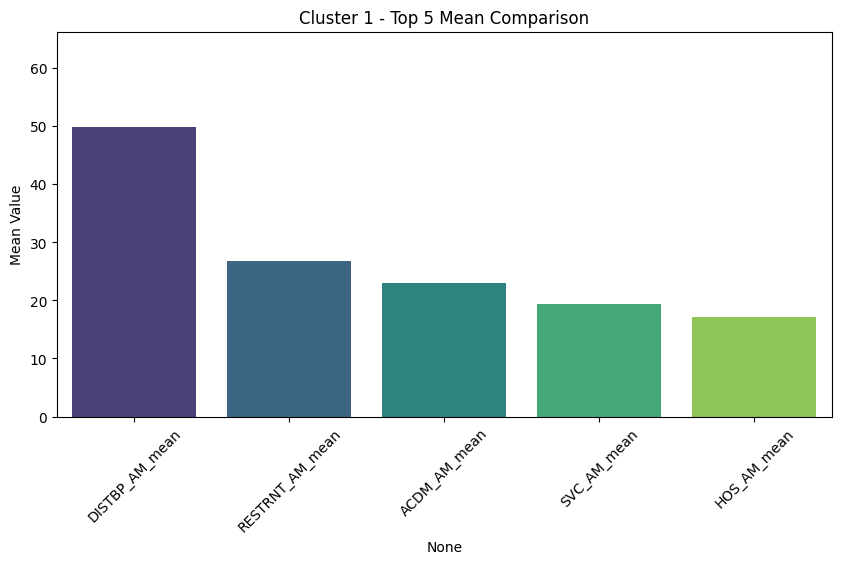

Cluster 2 - Top 5 Features:
['DISTBP_AM_mean', 'RESTRNT_AM_mean', 'SVC_AM_mean', 'HOS_AM_mean', 'FUEL_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


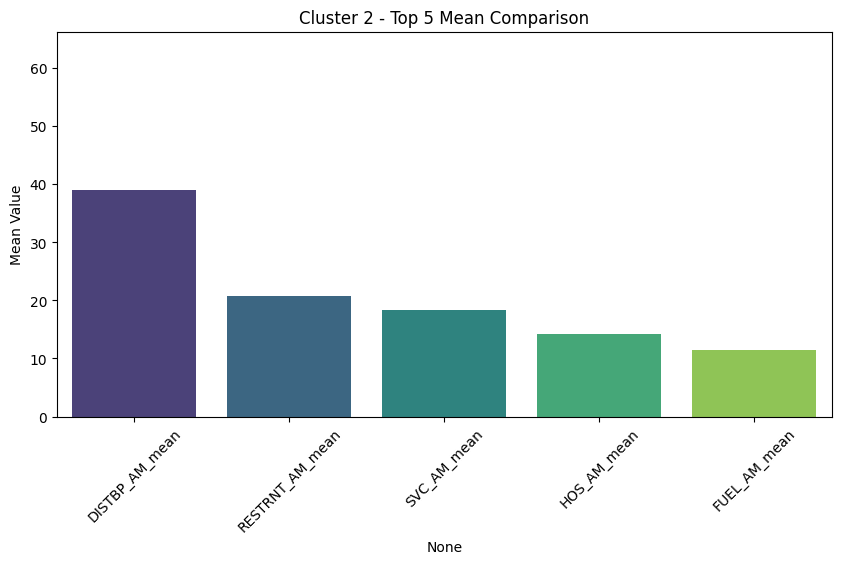

Cluster 3 - Top 5 Features:
['SVC_AM_mean', 'DISTBP_AM_mean', 'HOS_AM_mean', 'RESTRNT_AM_mean', 'ACDM_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


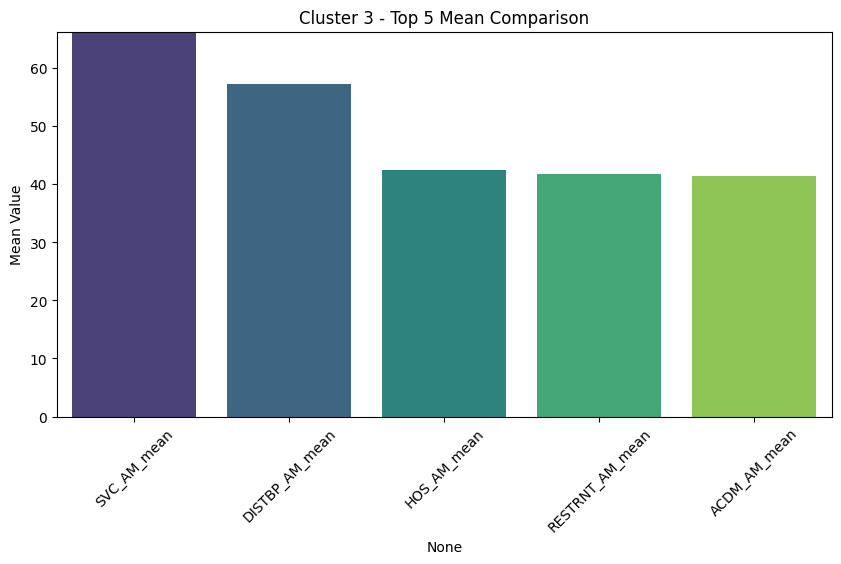

Cluster 4 - Top 5 Features:
['DISTBP_AM_mean', 'HOS_AM_mean', 'RESTRNT_AM_mean', 'SVC_AM_mean', 'GROCERY_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


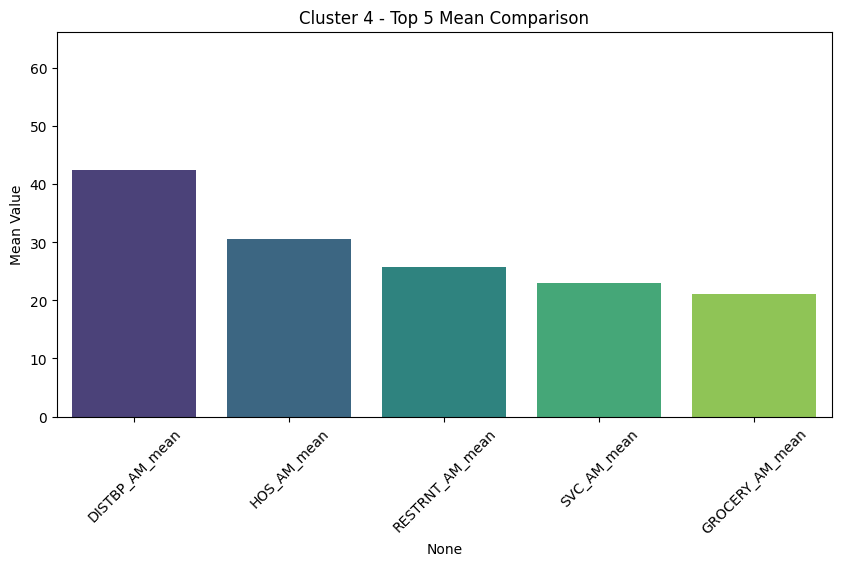

Cluster 5 - Top 5 Features:
['DISTBP_AM_mean', 'HOS_AM_mean', 'RESTRNT_AM_mean', 'GROCERY_AM_mean', 'SVC_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


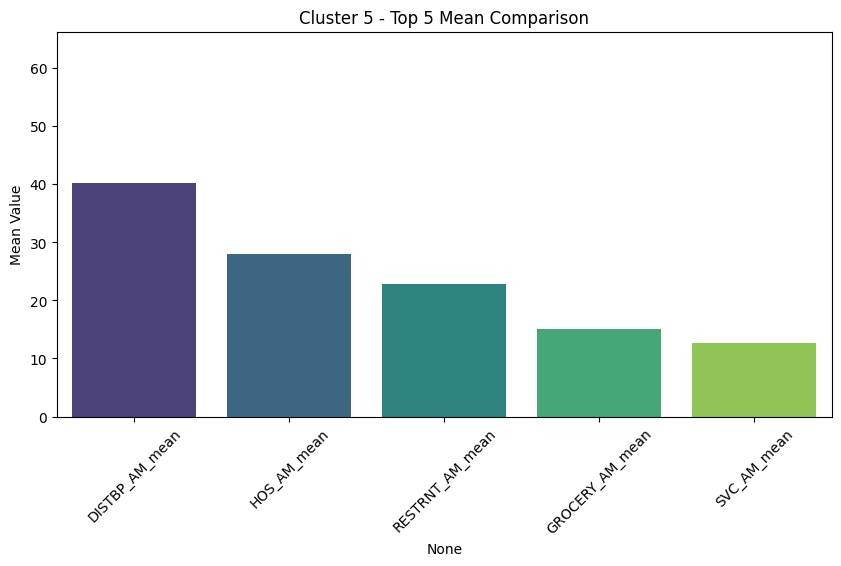

Cluster 6 - Top 5 Features:
['DISTBP_AM_mean', 'RESTRNT_AM_mean', 'SVC_AM_mean', 'HOS_AM_mean', 'FUEL_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


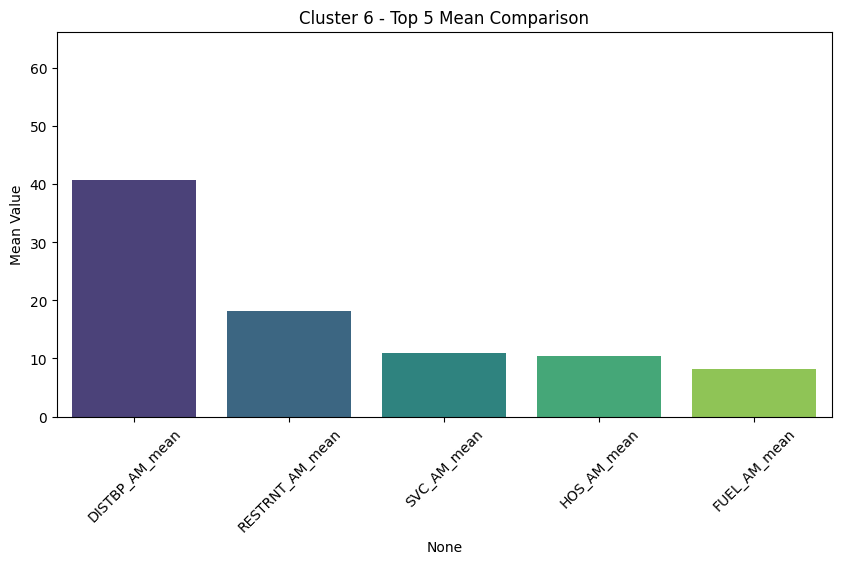

Cluster 7 - Top 5 Features:
['DISTBP_AM_mean', 'HOS_AM_mean', 'RESTRNT_AM_mean', 'GROCERY_AM_mean', 'SVC_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


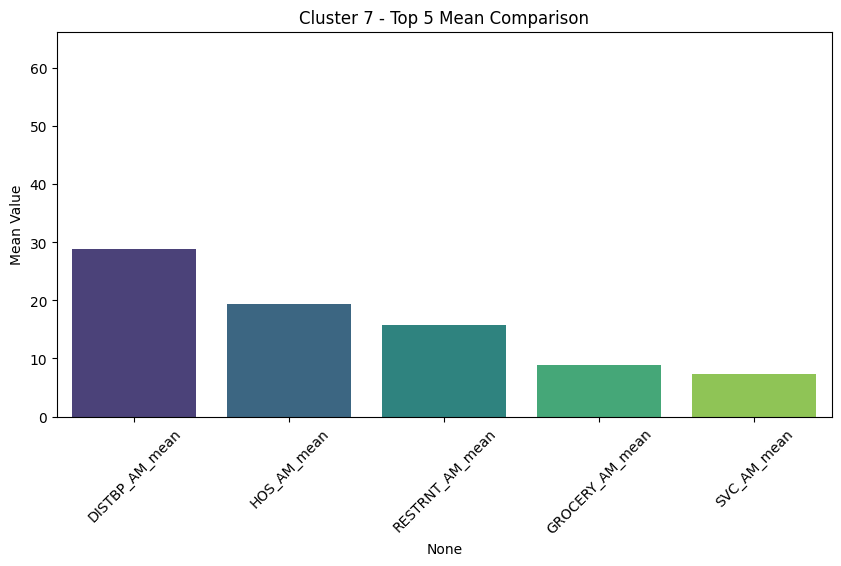

Cluster 8 - Top 5 Features:
['DISTBP_AM_mean', 'RESTRNT_AM_mean', 'SVC_AM_mean', 'HOS_AM_mean', 'BLDMNG_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


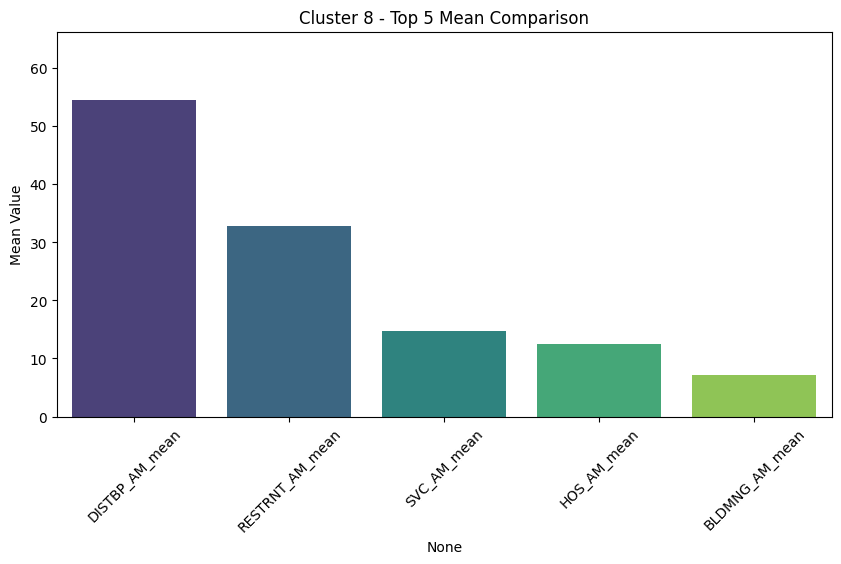

Cluster 9 - Top 5 Features:
['DISTBP_AM_mean', 'RESTRNT_AM_mean', 'SVC_AM_mean', 'ACDM_AM_mean', 'HOS_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


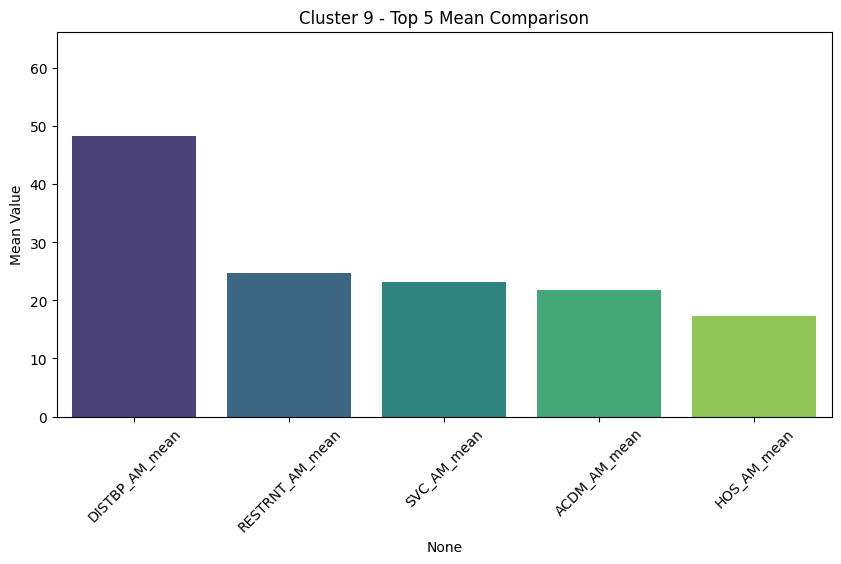

Cluster 10 - Top 5 Features:
['DISTBP_AM_mean', 'RESTRNT_AM_mean', 'FUEL_AM_mean', 'SVC_AM_mean', 'HOS_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


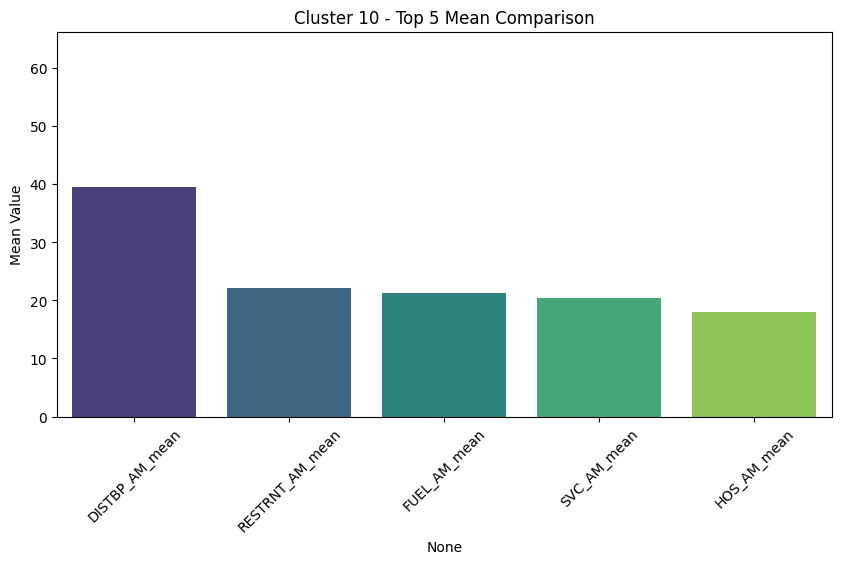

Cluster 11 - Top 5 Features:
['DISTBP_AM_mean', 'SVC_AM_mean', 'RESTRNT_AM_mean', 'HOS_AM_mean', 'FUEL_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


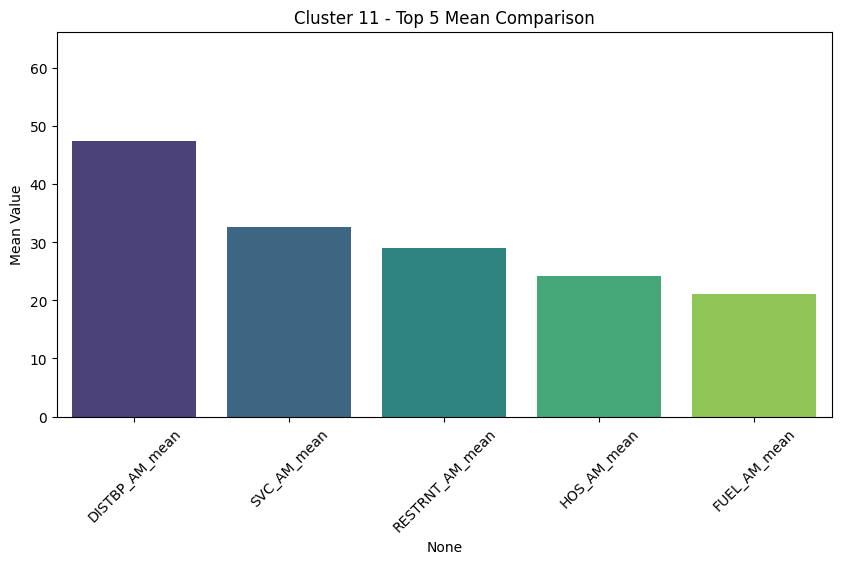

Cluster 12 - Top 5 Features:
['DISTBP_AM_mean', 'SVC_AM_mean', 'RESTRNT_AM_mean', 'ACDM_AM_mean', 'HOS_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


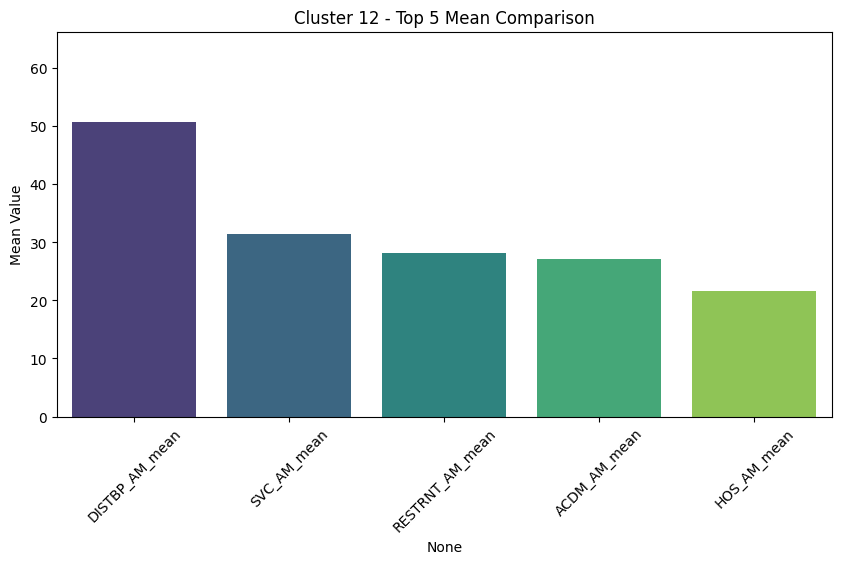

<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


Cluster 13 - Top 5 Features:
['DISTBP_AM_mean', 'RESTRNT_AM_mean', 'SVC_AM_mean', 'HOS_AM_mean', 'FUEL_AM_mean']




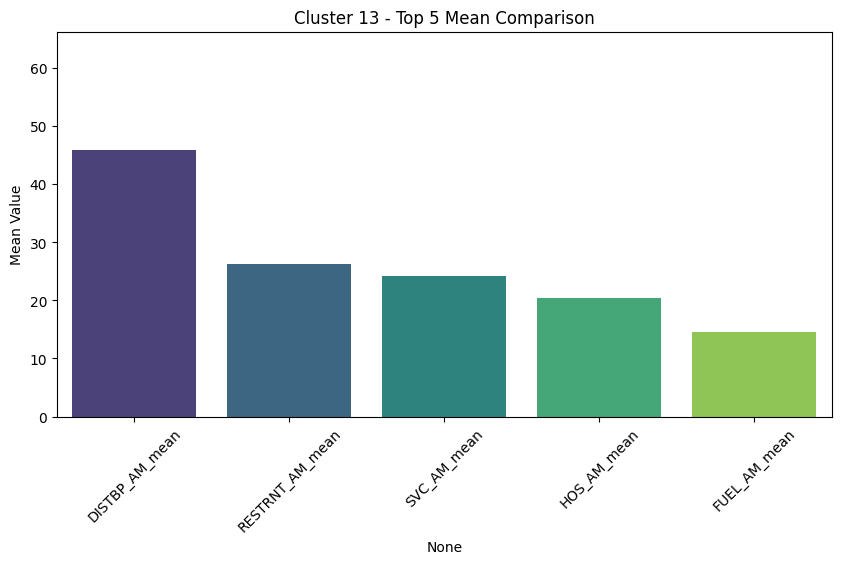

Cluster 14 - Top 5 Features:
['DISTBP_AM_mean', 'RESTRNT_AM_mean', 'HOS_AM_mean', 'SVC_AM_mean', 'BLDMNG_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


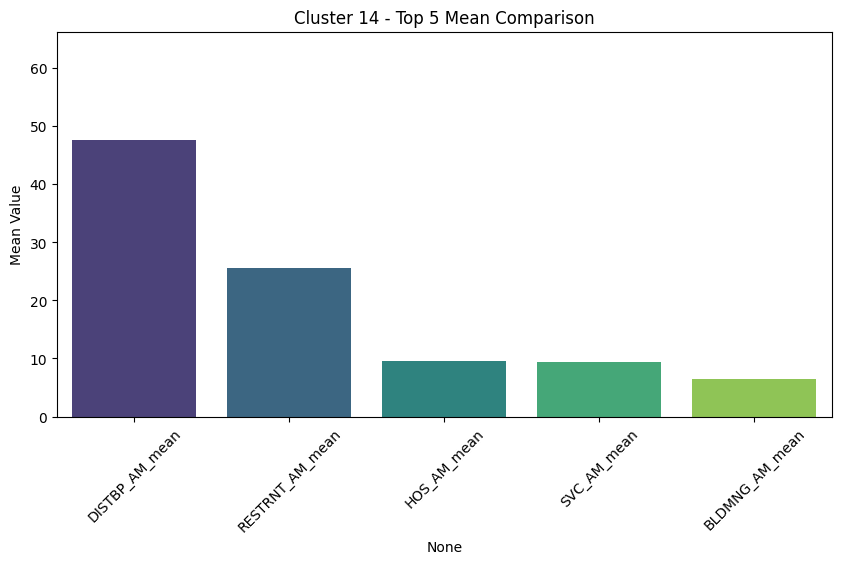

Cluster 15 - Top 5 Features:
['DISTBP_AM_mean', 'RESTRNT_AM_mean', 'SVC_AM_mean', 'HOS_AM_mean', 'ACDM_AM_mean']




<ipython-input-49-44a3c321a8fc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")


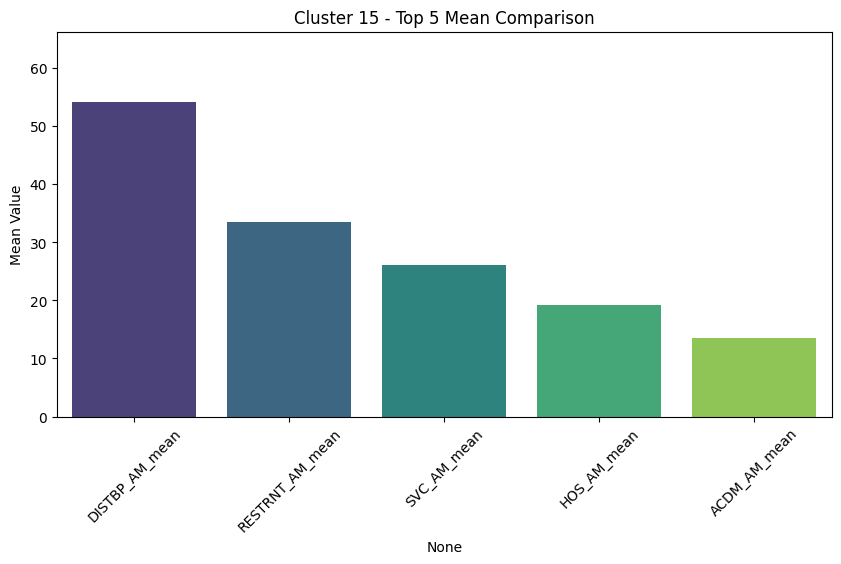

In [ ]:
cluster_means = features_copy.groupby("cluster")[numerical_vars].mean().reset_index()

# 반복문으로 클러스터별 시각화
for cluster_num in cluster_means["cluster"]:
    mean_values = cluster_means[cluster_means["cluster"] == cluster_num].iloc[:, 1:]

    # 내림차순 정렬 후 상위 5개 선택
    top5_values = mean_values.T.sort_values(by=mean_values.index[0], ascending=False).head(5)

    # top5 변수 출력
    print(f"Cluster {cluster_num} - Top 5 Features:")
    print(top5_values.index.tolist())
    print("\n")

    plt.figure(figsize=(10, 5))

    # 바 차트 그리기
    sns.barplot(x=top5_values.index, y=top5_values[mean_values.index[0]], palette="viridis")

    # 제목 및 축 레이블 설정
    plt.title(f"Cluster {cluster_num} - Top 5 Mean Comparison")
    plt.xticks(rotation=45)  # x축 레이블 가독성을 위해 회전
    plt.ylabel("Mean Value")
    plt.ylim(0, cluster_means[numerical_vars].max().max())  # y축을 전체 클러스터 기준으로 고정

    plt.show()

In [ ]:
features_copy.head()

AGE  SEX_CD  MBR_RK  LIFE_STAGE  DIGT_CHNL_REG_YN  DIGT_CHNL_USE_YN  \
0    1       1       3           0                 1                 0   
1    4       0       1           7                 1                 0   
2    0       1       4           4                 1                 0   
3    4       1       3           7                 0                 0   
4    4       1       4           7                 0                 0   

   TOT_USE_AM_mean  CRDSL_USE_AM_mean  CNF_USE_AM_mean  INTERIOR_AM_mean  \
0           705.00             532.50            167.5               0.0   
1           236.25             236.25              0.0               0.0   
2            71.25               0.00             67.5               0.0   
3           153.75               1.25            145.0               0.0   
4           180.00             180.00              0.0               0.0   

   INSUHOS_AM_mean  OFFEDU_AM_mean  TRVLEC_AM_mean  FSBZ_AM_mean  \
0            86.25           78.75            6.25         55.00   
1             0.00            0.00          135.00          3.75   
2            20.00            0.00            0.00          3.75   
3            13.75            0.00            1.25         23.75   
4             0.00            0.00            0.00          0.00   

   SVCARC_AM_mean  DIST_AM_mean  PLSANIT_AM_mean  CLOTHGDS_AM_mean  \
0           11.25        397.50             5.00              1.25   
1           72.50          2.50             0.00              0.00   
2            7.50         23.75             0.00              0.00   
3            2.50         58.75            13.75             15.00   
4            0.00        180.00             0.00              0.00   

   AUTO_AM_mean  FUNITR_AM_mean  APPLNC_AM_mean  HLTHFS_AM_mean  \
0           0.0             0.0             0.0             0.0   
1           0.0             0.0             0.0             0.0   
2           0.0             0.0             0.0             0.0   
3           0.0             0.0             0.0             0.0   
4           0.0             0.0             0.0             0.0   

   BLDMNG_AM_mean  ARCHIT_AM_mean  OPTIC_AM_mean  AGRICTR_AM_mean  \
0            0.00             0.0            0.0              0.0   
1            0.00             0.0            0.0              0.0   
2            0.00             0.0            0.0              0.0   
3            1.25             0.0            0.0              0.0   
4            0.00             0.0            0.0              0.0   

   LEISURE_S_AM_mean  LEISURE_P_AM_mean  CULTURE_AM_mean  SANIT_AM_mean  \
0               2.50                0.0              0.0           5.00   
1             143.75                0.0              0.0           0.00   
2               0.00                0.0              0.0           0.00   
3               0.00                0.0              0.0           8.75   
4               0.00                0.0              0.0           0.00   

   INSU_AM_mean  OFFCOM_AM_mean  BOOK_AM_mean  RPR_AM_mean  HOTEL_AM_mean  \
0          50.0             0.0           0.0          0.0           1.25   
1           0.0             0.0           0.0          0.0           0.00   
2          20.0             0.0           0.0          0.0           0.00   
3           0.0             0.0           0.0          2.5           0.00   
4           0.0             0.0           0.0          0.0           0.00   

   GOODS_AM_mean  TRVL_AM_mean  FUEL_AM_mean  SVC_AM_mean  DISTBNP_AM_mean  \
0            0.0           0.0           0.0        11.25             0.00   
1            0.0           0.0           0.0        72.50             1.25   
2            0.0           0.0           0.0         7.50             0.00   
3           15.0           0.0           0.0         0.00             1.25   
4            0.0           0.0           0.0         0.00             0.00   

   DISTBP_AM_mean  GROCERY_AM_mean  HOS_AM_mean  CLOTH_AM_mean  \
0   

<ipython-input-38-71f863da0786>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='MONTH_DIFF', data=avg_membership_duration, palette='Blues_d')


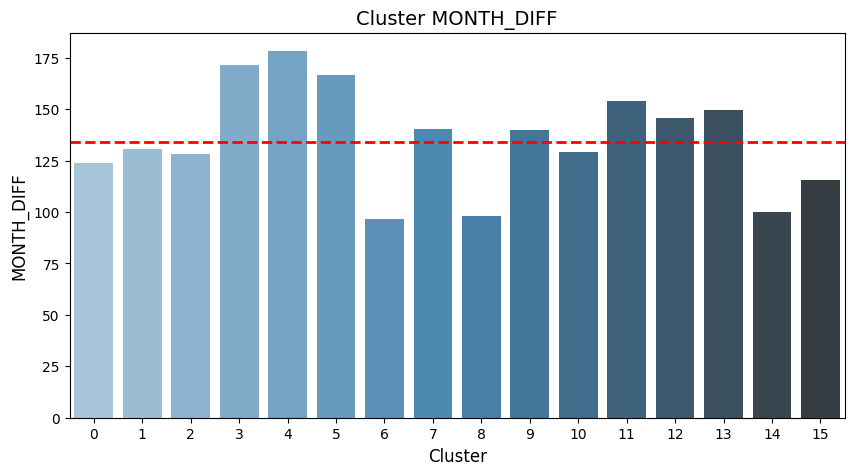

In [ ]:
avg_membership_duration = features_copy.groupby('cluster')['MONTH_DIFF'].mean().reset_index()

# seaborn을 사용하여 막대 그래프 그리기
plt.figure(figsize=(10, 5))
sns.barplot(x='cluster', y='MONTH_DIFF', data=avg_membership_duration, palette='Blues_d')
plt.axhline(y=134, color='red', linestyle='--', linewidth=2, label='y = 134')

# 그래프에 제목과 레이블 추가
plt.title('Cluster MONTH_DIFF', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('MONTH_DIFF', fontsize=12)

# 그래프 표시
plt.show()

In [ ]:
avg_membership_duration

cluster  MONTH_DIFF
0         0  123.671346
1         1  130.818065
2         2  128.299343
3         3  171.304315
4         4  178.311717
5         5  166.538281
6         6   96.579732
7         7  140.472381
8         8   98.312746
9         9  139.854981
10       10  129.357341
11       11  154.030129
12       12  145.936040
13       13  149.775196
14       14  100.009528
15       15  115.513436